In [1]:
import os
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from Bio import SeqIO
from joblib import Parallel, delayed

In [2]:
def load_csv_files(decoding_file_name:str):
    if decoding_file_name.endswith(".csv"):
        # dt=np.dtype({'names':['codon','average_decoding_time'],'formats':['S4',float]})
        # arr = np.loadtxt("decoding_times/" + decoding_file_name, delimiter=",", dtype=dt, skiprows=1)
        arr = np.genfromtxt("decoding_times/" + decoding_file_name, delimiter=",", usecols=(1), skip_header=1)
        # df = pd.read_csv("decoding_times/" + decoding_file_name)
        return (decoding_file_name, arr)


In [3]:
parallel = Parallel(n_jobs=-1, verbose=10)
results = parallel(delayed(load_csv_files)(decoding_file_name) for decoding_file_name in os.listdir("decoding_times/"))

decoding_files_dict = {}
for file_name, arr in results:
    decoding_files_dict[file_name] = arr

all_codons = pd.read_csv("decoding_times/base_configuration.csv", index_col=None).codon.values
baseline_arr = decoding_files_dict['base_configuration.csv']
# del decoding_files_dict['base_configuration.csv']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1969139575958252s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05069279670715332s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07796216011047363s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.4s
[Parallel(n_jobs

In [4]:
luc_sequences = {}
for fasta in SeqIO.parse(open("../../FLuc variants.txt"),'fasta'):
    name, sequence = fasta.id, str(fasta.seq)
    luc_sequences[name] = sequence

In [5]:
def codons(seq):
    n = len(seq)
    for i in range(0, n - 2, 3):
        # ignore start codon
        if i == 0:
            continue
        # ignore termination codon
        if i == n - 3:
            continue
        yield seq[i:i+3].replace('T', 'U')

def create_equation(sequence):
    # equation = {codon:0 for codon in all_codons}
    # for codon in codons(sequence):
    #     equation[codon] += 1
    # return equation
    equation = np.zeros(len(all_codons))
    for codon in codons(sequence):
        equation[np.where(all_codons == codon)] += 1
    return equation

In [6]:
def calculate_time(equation, baseline_arr, pairing_column):
    # total_time = 0
    # for codon in equation.keys():
    #     if equation[codon] == 0:
    #         continue
    #     xx = baseline_df[['codon', pairing_column]]
    #     total_time += xx[xx.codon == codon].iloc[0,1] * equation[codon]
    #     # total_time += baseline_df[baseline_df.codon==codon][pairing_column].values[0] * equation[codon]
    # return total_time
    return np.dot(equation, baseline_arr)

In [7]:
equations = {}
for s in luc_sequences.keys():
    equations[s] = create_equation(luc_sequences[s])

In [8]:
create_equation(luc_sequences['MinCFLuc'])

array([39., 10.,  0.,  9.,  0.,  0., 29.,  0.,  0.,  0., 10.,  0., 38.,
        0., 13.,  0.,  0.,  6., 16.,  8.,  0., 14.,  0., 15.,  0.,  0.,
       10.,  0.,  0., 51.,  0.,  0.,  0., 15., 33., 16., 21.,  0., 21.,
        0.,  1.,  0., 44.,  0., 16.,  0., 28.,  0., 11.,  8.,  0.,  0.,
       28.,  0.,  2.,  2.,  2.,  0., 12.,  0., 18.])

In [9]:
np.dot(create_equation(luc_sequences['MinCFLuc']), baseline_arr)

405.21671491538484

In [10]:
raw_times_matrix = np.zeros((len(decoding_files_dict), 3))
basepairs_list = list(decoding_files_dict.keys())

In [11]:
base_pairing_matrix = np.zeros((len(decoding_files_dict), 61))
for i in range(raw_times_matrix.shape[0]):
    base_pairing_matrix[i, :] = decoding_files_dict[basepairs_list[i]]

In [12]:
base_pairing_matrix[0,:]

array([0.45746986, 0.32717842, 0.22973445, 0.55894851, 0.3499639 ,
       0.38212606, 0.68767234, 0.2295128 , 0.14805877, 1.39449126,
       0.30677561, 1.74791202, 0.44385831, 0.4710953 , 0.55269787,
       0.27777236, 0.46596765, 0.53262363, 0.64569875, 0.7879455 ,
       0.31724377, 2.18620209, 0.44917487, 1.79480821, 0.50995783,
       0.63371032, 2.19863336, 0.39195873, 1.36888363, 1.20684796,
       1.46672192, 1.29317487, 0.30272511, 0.28024173, 0.46570697,
       0.50696697, 0.32693155, 0.37006533, 0.85287264, 0.22539175,
       1.02287402, 0.171761  , 0.6829728 , 0.38599858, 0.40486429,
       0.51366426, 0.9932835 , 0.2851227 , 0.53383855, 0.78764469,
       0.37786289, 0.54059483, 0.79025189, 0.31080013, 0.70488251,
       0.35290559, 0.98238985, 0.57925509, 0.34263081, 0.26409068,
       0.58009188])

In [13]:
for i in range(raw_times_matrix.shape[0]):
    for j, luc_equation in enumerate(equations.values()):
        raw_times_matrix[i, j] = np.dot(luc_equation, base_pairing_matrix[i,:])

In [14]:
raw_times_matrix

array([[404.85737833, 313.36018453, 161.18253021],
       [506.82137066, 312.78477522, 156.11202127],
       [404.82136236, 313.37325342, 161.24031326],
       ...,
       [419.46011063, 313.06499911, 161.05518527],
       [392.7833441 , 328.68446809, 151.58615628],
       [493.59086598, 364.307738  , 148.89500147]])

In [15]:
relative_expression_levels = np.zeros(raw_times_matrix.shape)
for i in range(relative_expression_levels.shape[0]):
    for j, luc_equation in enumerate(equations.values()):
        relative_expression_levels[i, j] = raw_times_matrix[i,1] / raw_times_matrix[i,j]
relative_expression_levels

array([[0.77400142, 1.        , 1.94413243],
       [0.61714993, 1.        , 2.00359186],
       [0.77410256, 1.        , 1.94351677],
       ...,
       [0.74635225, 1.        , 1.94383682],
       [0.83680857, 1.        , 2.16830136],
       [0.73807634, 1.        , 2.44674257]])

In [16]:
error_expression_levels = np.zeros(raw_times_matrix.shape[0])
for i in range(error_expression_levels.shape[0]):
    error_expression_levels[i] = np.power(relative_expression_levels[i, 0] - 0.28, 2) + np.power(relative_expression_levels[i, 2] - 1.9, 2)
error_expression_levels

array([0.24598507, 0.12440135, 0.24603105, ..., 0.21940609, 0.3820214 ,
       0.50876136])

In [17]:
index_min = np.argmin(error_expression_levels)

In [18]:
error_expression_levels[index_min]

0.11088509281774381

In [19]:
relative_expression_levels[index_min]

array([0.59754567, 1.        , 2.00024889])

In [20]:
basepairs_list[index_min]

'Wo_C_U Wo_G_A Wo_G_1.csv'

In [21]:
pd.DataFrame(data={'construct': basepairs_list, 'MinCFLuc':raw_times_matrix[:,0], 'StaCFLuc':raw_times_matrix[:, 1], 'MaxCFLuc':raw_times_matrix[:, 2]}).set_index(['construct'])

MinCFLuc    StaCFLuc    MaxCFLuc
construct                                                   
Wo_G_S Wo_G_).csv         404.857378  313.360185  161.182530
Wo_A_M Wo_C_U.csv         506.821371  312.784775  156.112021
Wo_G_V Wo_U_V.csv         404.821362  313.373253  161.240313
Wo_A_M Wo_G_).csv         404.800124  313.328039  161.167774
Wo_G_A Wo_U_V.csv         392.678094  301.698286  155.140118
...                              ...         ...         ...
Wo_A_M Wo_G_N Wo_G_?.csv  486.961457  337.522716  161.164899
Wo_C_U Wo_G_A Wo_U_V.csv  494.366451  300.904367  150.075400
Wo_G_1 Wo_G_) Wo_G_P.csv  419.460111  313.064999  161.055185
Wo_G_V Wo_U_U Wo_U_V.csv  392.783344  328.684468  151.586156
Wo_A_M Wo_G_3 Wo_U_U.csv  493.590866  364.307738  148.895001

[1794 rows x 3 columns]

In [22]:
rel_exp_level_df = pd.DataFrame(data={'construct': basepairs_list, 'MinCFLuc':relative_expression_levels[:,0], 'StaCFLuc':relative_expression_levels[:, 1], 'MaxCFLuc':relative_expression_levels[:, 2], 'error':error_expression_levels}).set_index(['construct'])
rel_exp_level_df

MinCFLuc  StaCFLuc  MaxCFLuc     error
construct                                                       
Wo_G_S Wo_G_).csv         0.774001       1.0  1.944132  0.245985
Wo_A_M Wo_C_U.csv         0.617150       1.0  2.003592  0.124401
Wo_G_V Wo_U_V.csv         0.774103       1.0  1.943517  0.246031
Wo_A_M Wo_G_).csv         0.774031       1.0  1.944111  0.246013
Wo_G_A Wo_U_V.csv         0.768309       1.0  1.944683  0.240443
...                            ...       ...       ...       ...
Wo_A_M Wo_G_N Wo_G_?.csv  0.693120       1.0  2.094269  0.208409
Wo_C_U Wo_G_A Wo_U_V.csv  0.608667       1.0  2.005021  0.119051
Wo_G_1 Wo_G_) Wo_G_P.csv  0.746352       1.0  1.943837  0.219406
Wo_G_V Wo_U_U Wo_U_V.csv  0.836809       1.0  2.168301  0.382021
Wo_A_M Wo_G_3 Wo_U_U.csv  0.738076       1.0  2.446743  0.508761

[1794 rows x 4 columns]

In [23]:
rel_exp_level_df.sort_values('error')

MinCFLuc  StaCFLuc  MaxCFLuc     error
construct                                                       
Wo_C_U Wo_G_A Wo_G_1.csv  0.597546       1.0  2.000249  0.110885
Wo_C_U Wo_G_1 Wo_G_~.csv  0.607442       1.0  1.965434  0.111500
Wo_C_U Wo_G_A Wo_G_~.csv  0.611116       1.0  1.962168  0.113502
Wo_C_U Wo_G_1 Wo_G_P.csv  0.605682       1.0  1.996489  0.115379
Wo_C_U Wo_G_1 Wo_U_W.csv  0.606002       1.0  1.998180  0.115917
...                            ...       ...       ...       ...
Wo_G_3 Wo_G_P Wo_U_U.csv  0.738236       1.0  2.453051  0.515845
Wo_G_A Wo_G_3 Wo_U_U.csv  0.737995       1.0  2.461936  0.525532
Wo_A_A Wo_G_3 Wo_U_U.csv  0.736196       1.0  2.497672  0.565327
Wo_G_& Wo_G_3 Wo_U_U.csv  0.716529       1.0  2.537499  0.596963
Wo_G_3 Wo_G_N Wo_U_U.csv  0.685929       1.0  2.595652  0.648710

[1794 rows x 4 columns]

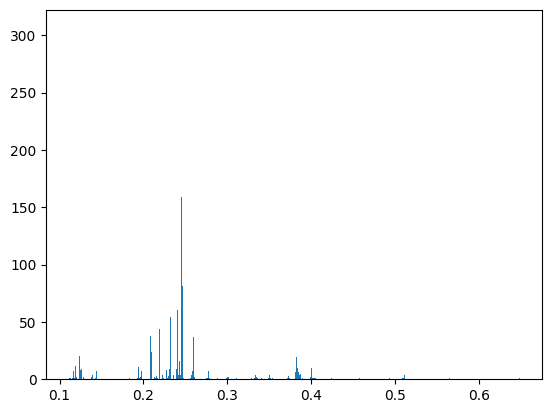

In [24]:
plt.hist(error_expression_levels, bins=1000);

In [25]:
constructs = rel_exp_level_df.sort_values('error').iloc[:4].index
constructs

Index(['Wo_C_U Wo_G_A Wo_G_1.csv', 'Wo_C_U Wo_G_1 Wo_G_~.csv',
       'Wo_C_U Wo_G_A Wo_G_~.csv', 'Wo_C_U Wo_G_1 Wo_G_P.csv'],
      dtype='object', name='construct')

In [26]:
def generate_sub_file_names(construct_name):
    exclusions = construct_name.split('.')[0].split(' ')
    files_names = []
    for i in range(1, len(exclusions) + 1):
        files_names.append(" ".join(exclusions[0:i]))
        files_names[-1] = files_names[-1] + ".csv"
    return files_names

In [27]:
def generate_individual_file_names(construct_name):
    exclusions = construct_name.split('.')[0].split(' ')
    files_names = []
    for i in range(len(exclusions)):
        files_names.append(exclusions[i])
        files_names[-1] = files_names[-1] + ".csv"
    return files_names    

In [28]:
generate_individual_file_names(constructs[0])

['Wo_C_U.csv', 'Wo_G_A.csv', 'Wo_G_1.csv']

In [29]:
generate_sub_file_names(constructs[0])

['Wo_C_U.csv', 'Wo_C_U Wo_G_A.csv', 'Wo_C_U Wo_G_A Wo_G_1.csv']

In [30]:
dfs = [rel_exp_level_df[rel_exp_level_df.index.isin(generate_sub_file_names(c))].sort_values('construct', ascending=False) for c in constructs]
pd.concat(dfs)

MinCFLuc  StaCFLuc  MaxCFLuc     error
construct                                                       
Wo_C_U.csv                0.618085       1.0  2.000924  0.124487
Wo_C_U Wo_G_A.csv         0.608498       1.0  2.004649  0.118862
Wo_C_U Wo_G_A Wo_G_1.csv  0.597546       1.0  2.000249  0.110885
Wo_C_U.csv                0.618085       1.0  2.000924  0.124487
Wo_C_U Wo_G_1.csv         0.606173       1.0  2.001821  0.116757
Wo_C_U Wo_G_1 Wo_G_~.csv  0.607442       1.0  1.965434  0.111500
Wo_C_U.csv                0.618085       1.0  2.000924  0.124487
Wo_C_U Wo_G_A.csv         0.608498       1.0  2.004649  0.118862
Wo_C_U Wo_G_A Wo_G_~.csv  0.611116       1.0  1.962168  0.113502
Wo_C_U.csv                0.618085       1.0  2.000924  0.124487
Wo_C_U Wo_G_1.csv         0.606173       1.0  2.001821  0.116757
Wo_C_U Wo_G_1 Wo_G_P.csv  0.605682       1.0  1.996489  0.115379

In [31]:
pd.concat(dfs).to_csv("partial_pairings_configurations.csv")

In [32]:
rel_exp_level_df[rel_exp_level_df.index =='base_configuration.csv']

MinCFLuc  StaCFLuc  MaxCFLuc     error
construct                                                     
base_configuration.csv  0.773865       1.0  1.945674  0.245989

In [33]:
dfs = [rel_exp_level_df[rel_exp_level_df.index.isin(generate_individual_file_names(c))].sort_values('construct', ascending=False) for c in constructs] + [rel_exp_level_df[rel_exp_level_df.index =='base_configuration.csv']]
pd.concat(dfs)

MinCFLuc  StaCFLuc  MaxCFLuc     error
construct                                                     
Wo_G_A.csv              0.768471       1.0  1.945176  0.240645
Wo_G_1.csv              0.746326       1.0  1.943056  0.219314
Wo_C_U.csv              0.618085       1.0  2.000924  0.124487
Wo_G_~.csv              0.776657       1.0  1.912062  0.246813
Wo_G_1.csv              0.746326       1.0  1.943056  0.219314
Wo_C_U.csv              0.618085       1.0  2.000924  0.124487
Wo_G_~.csv              0.776657       1.0  1.912062  0.246813
Wo_G_A.csv              0.768471       1.0  1.945176  0.240645
Wo_C_U.csv              0.618085       1.0  2.000924  0.124487
Wo_G_P.csv              0.774133       1.0  1.944269  0.246127
Wo_G_1.csv              0.746326       1.0  1.943056  0.219314
Wo_C_U.csv              0.618085       1.0  2.000924  0.124487
base_configuration.csv  0.773865       1.0  1.945674  0.245989

In [34]:
pd.concat(dfs).to_csv("individual_pairings_configurations.csv")

In [35]:
from concentrations import concentrations_generator

In [36]:
tRNAs = pd.read_csv('/home/heday//Projects/R_concentrations//data/tRNAs.csv')
codons = pd.read_csv('/home/heday/Projects/R_concentrations/data/codons.csv')

In [37]:
def generate_plot(file_name):
    concentrations_generator.plot_matrix(
        concentrations_generator.make_matrix(
            tRNAs, codons, verbose=False, settings_file_name="pairings/"+file_name.replace('.csv', '.json')), tRNAs, codons, save_fig='pairing_plots/'+file_name.replace('.csv', '.png'))

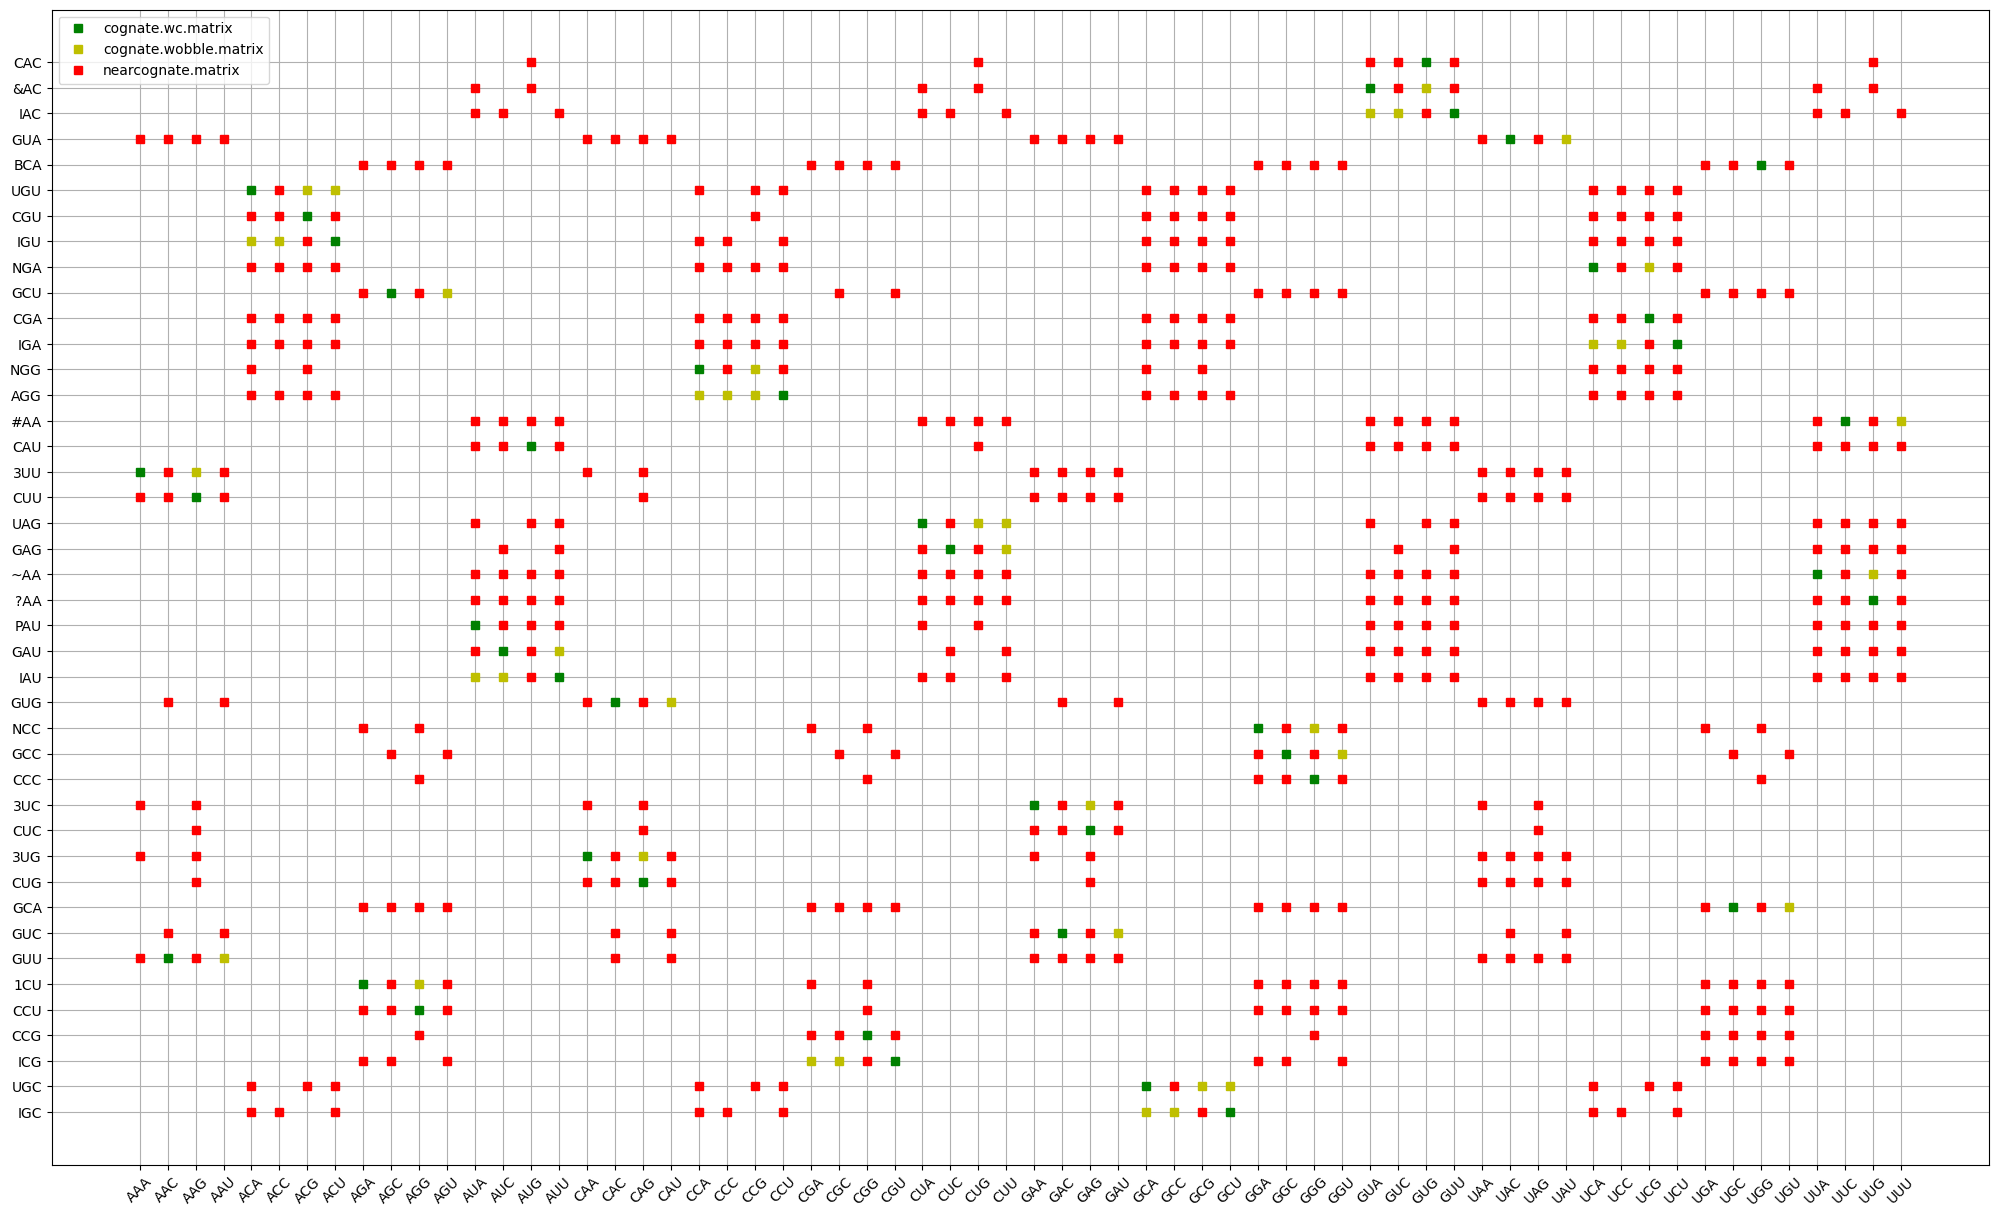

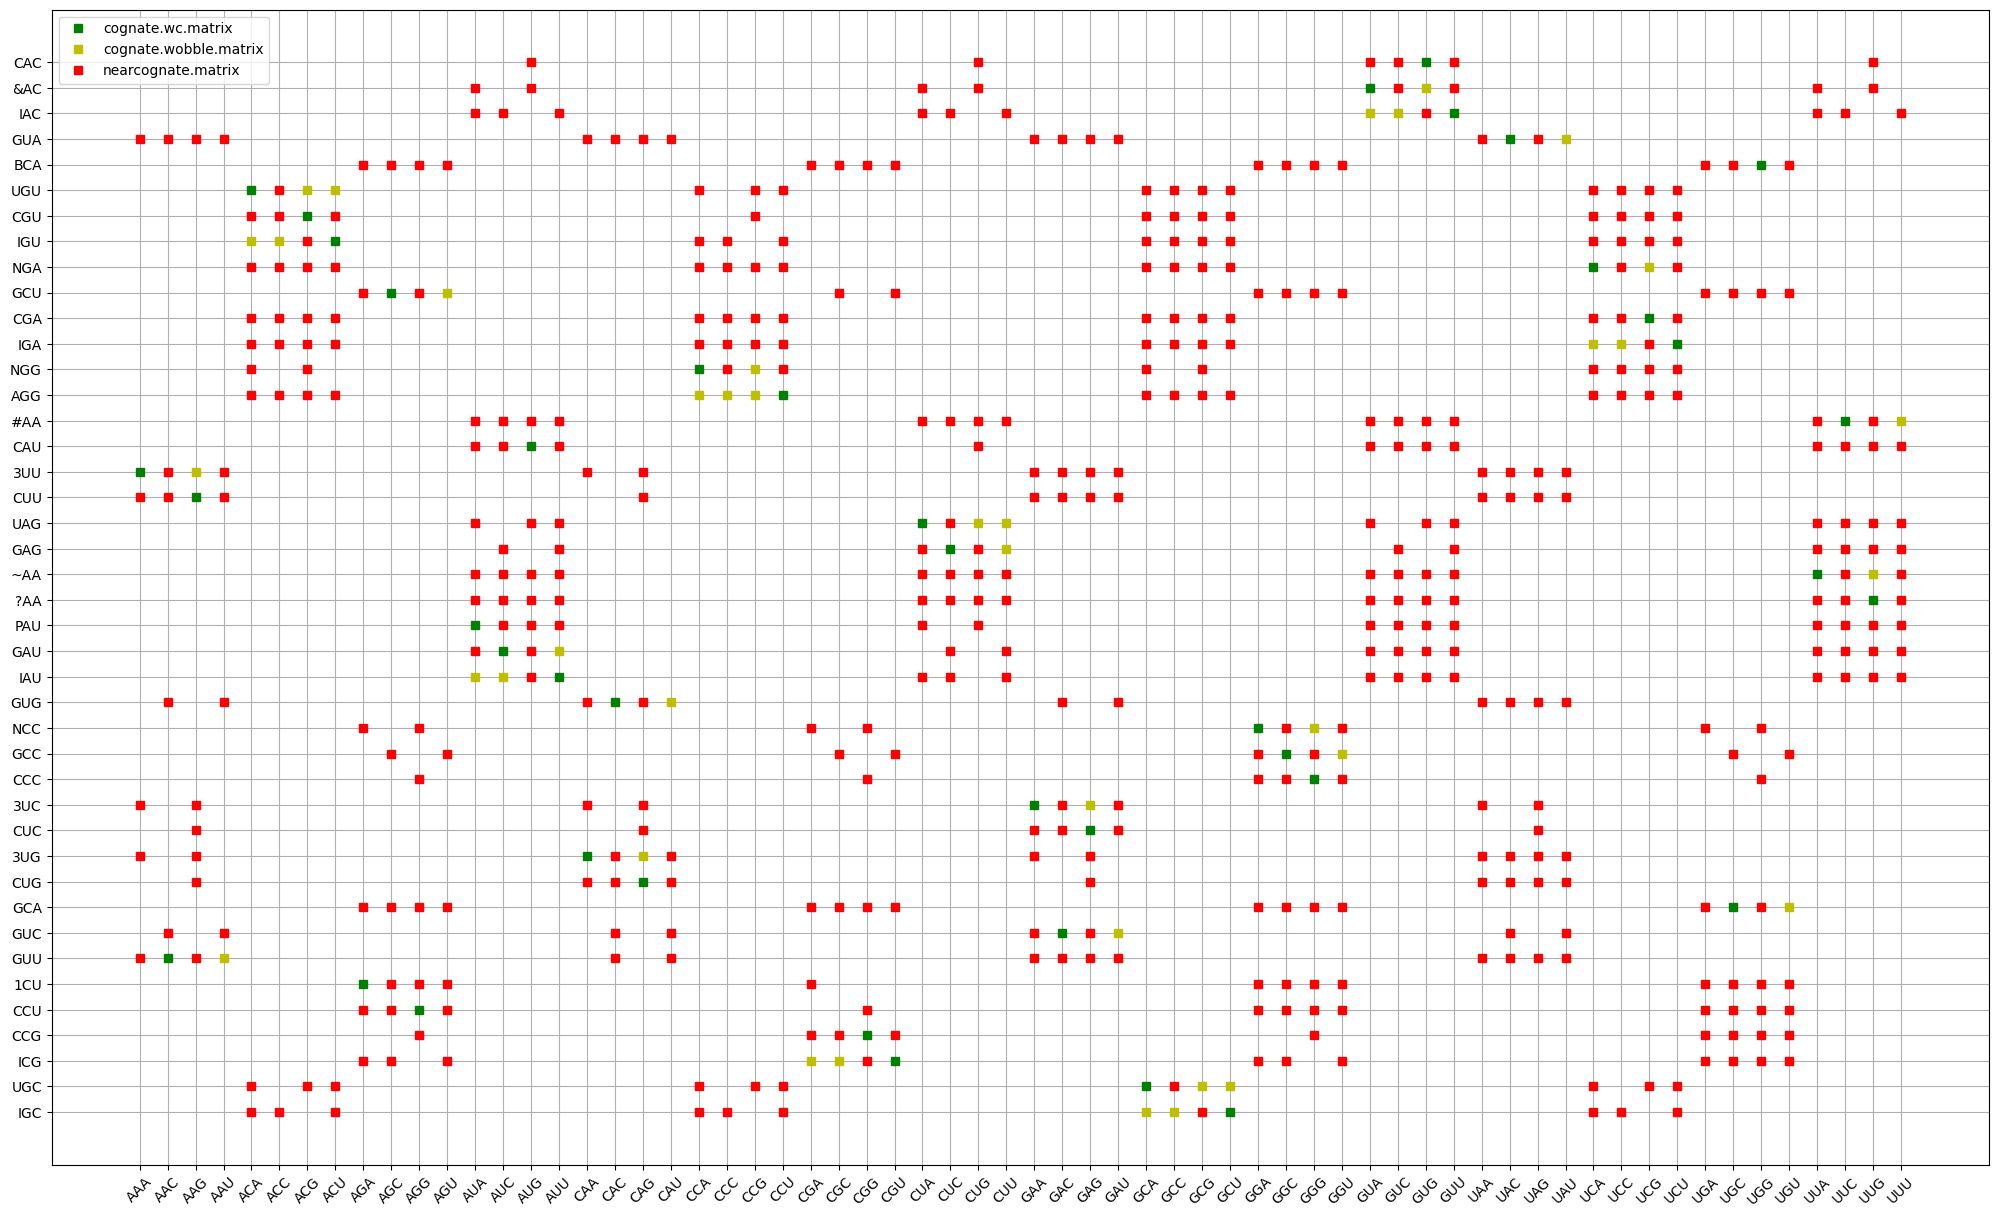

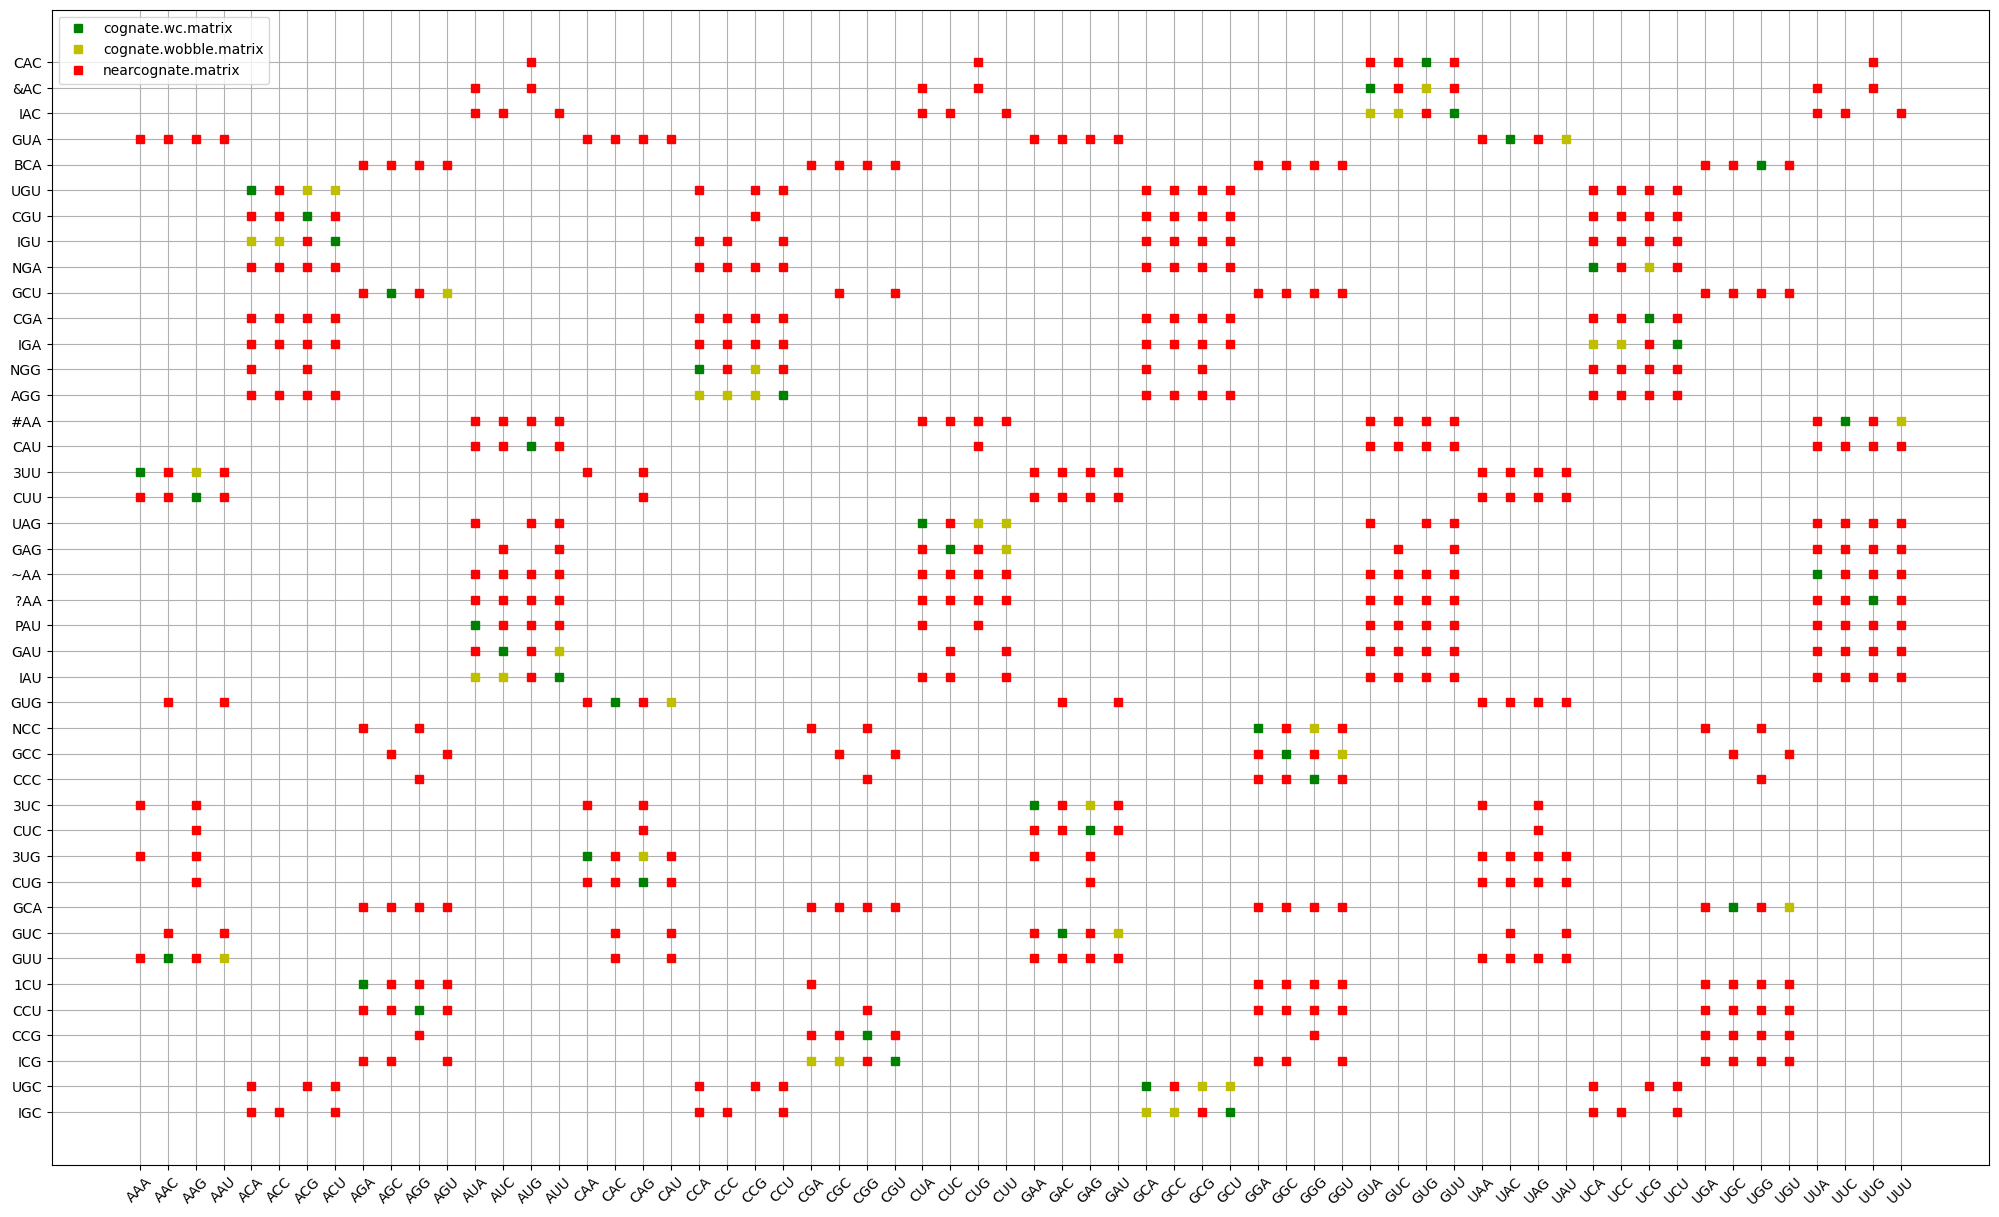

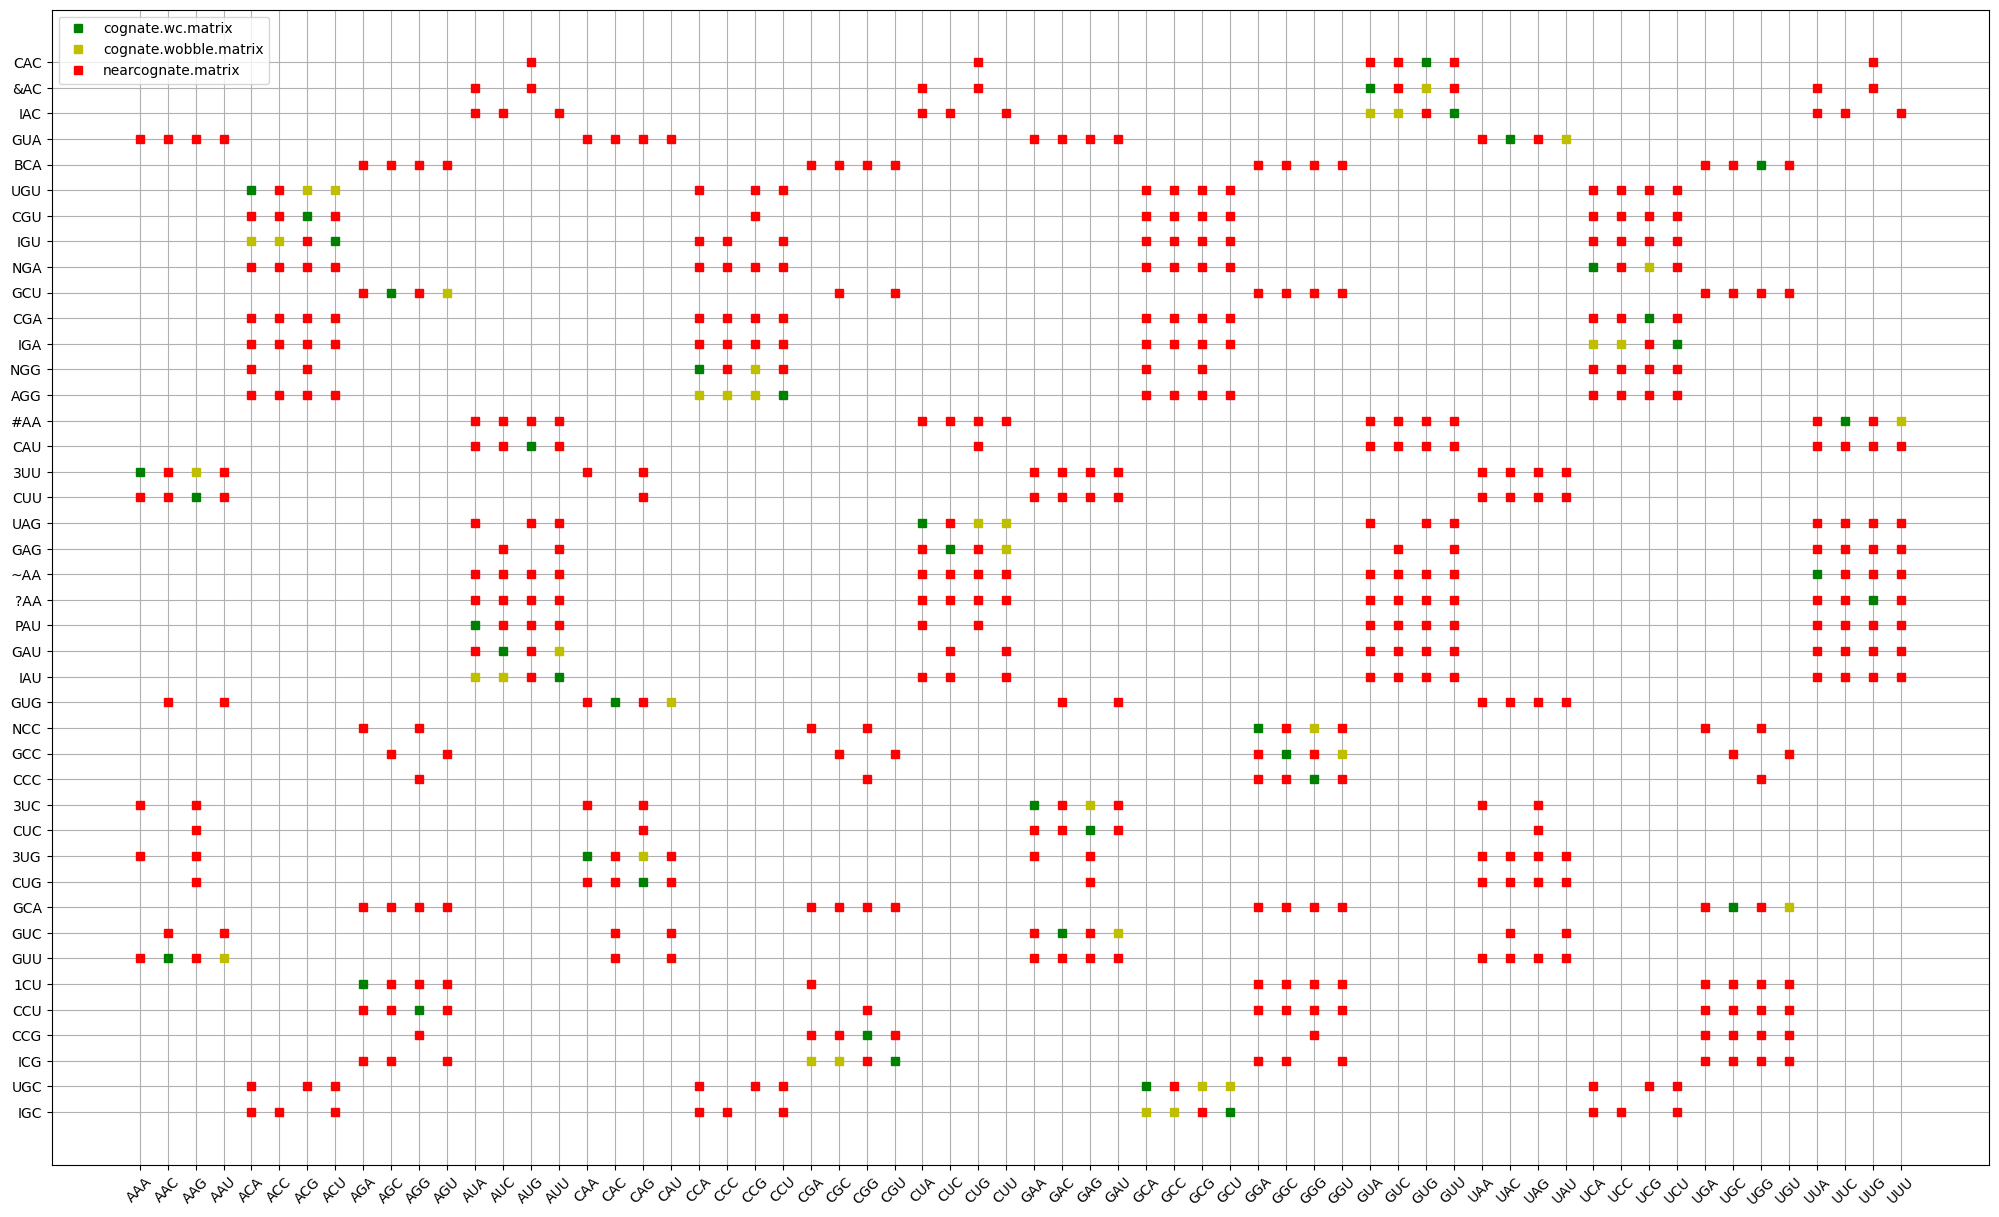

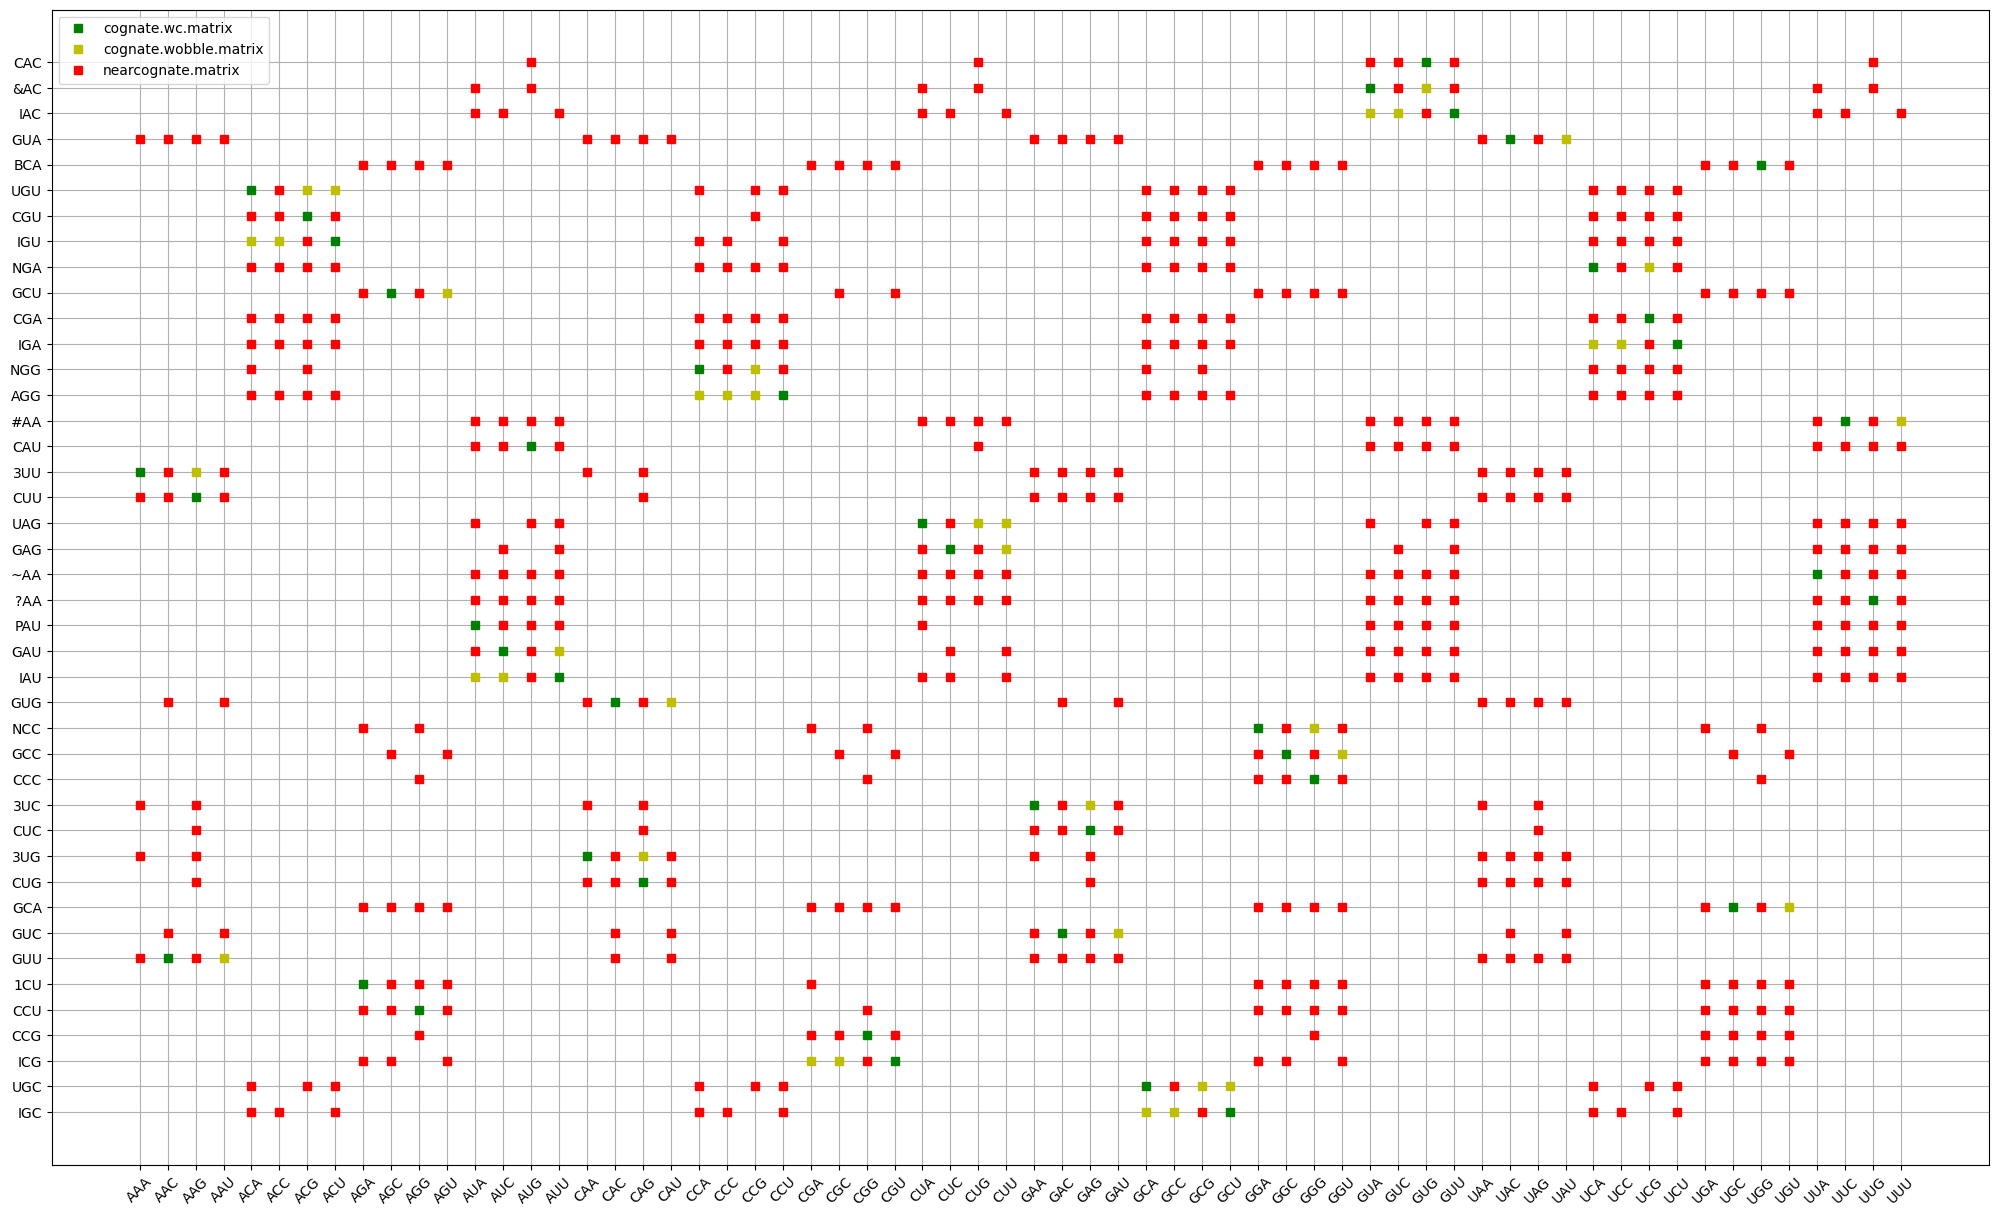

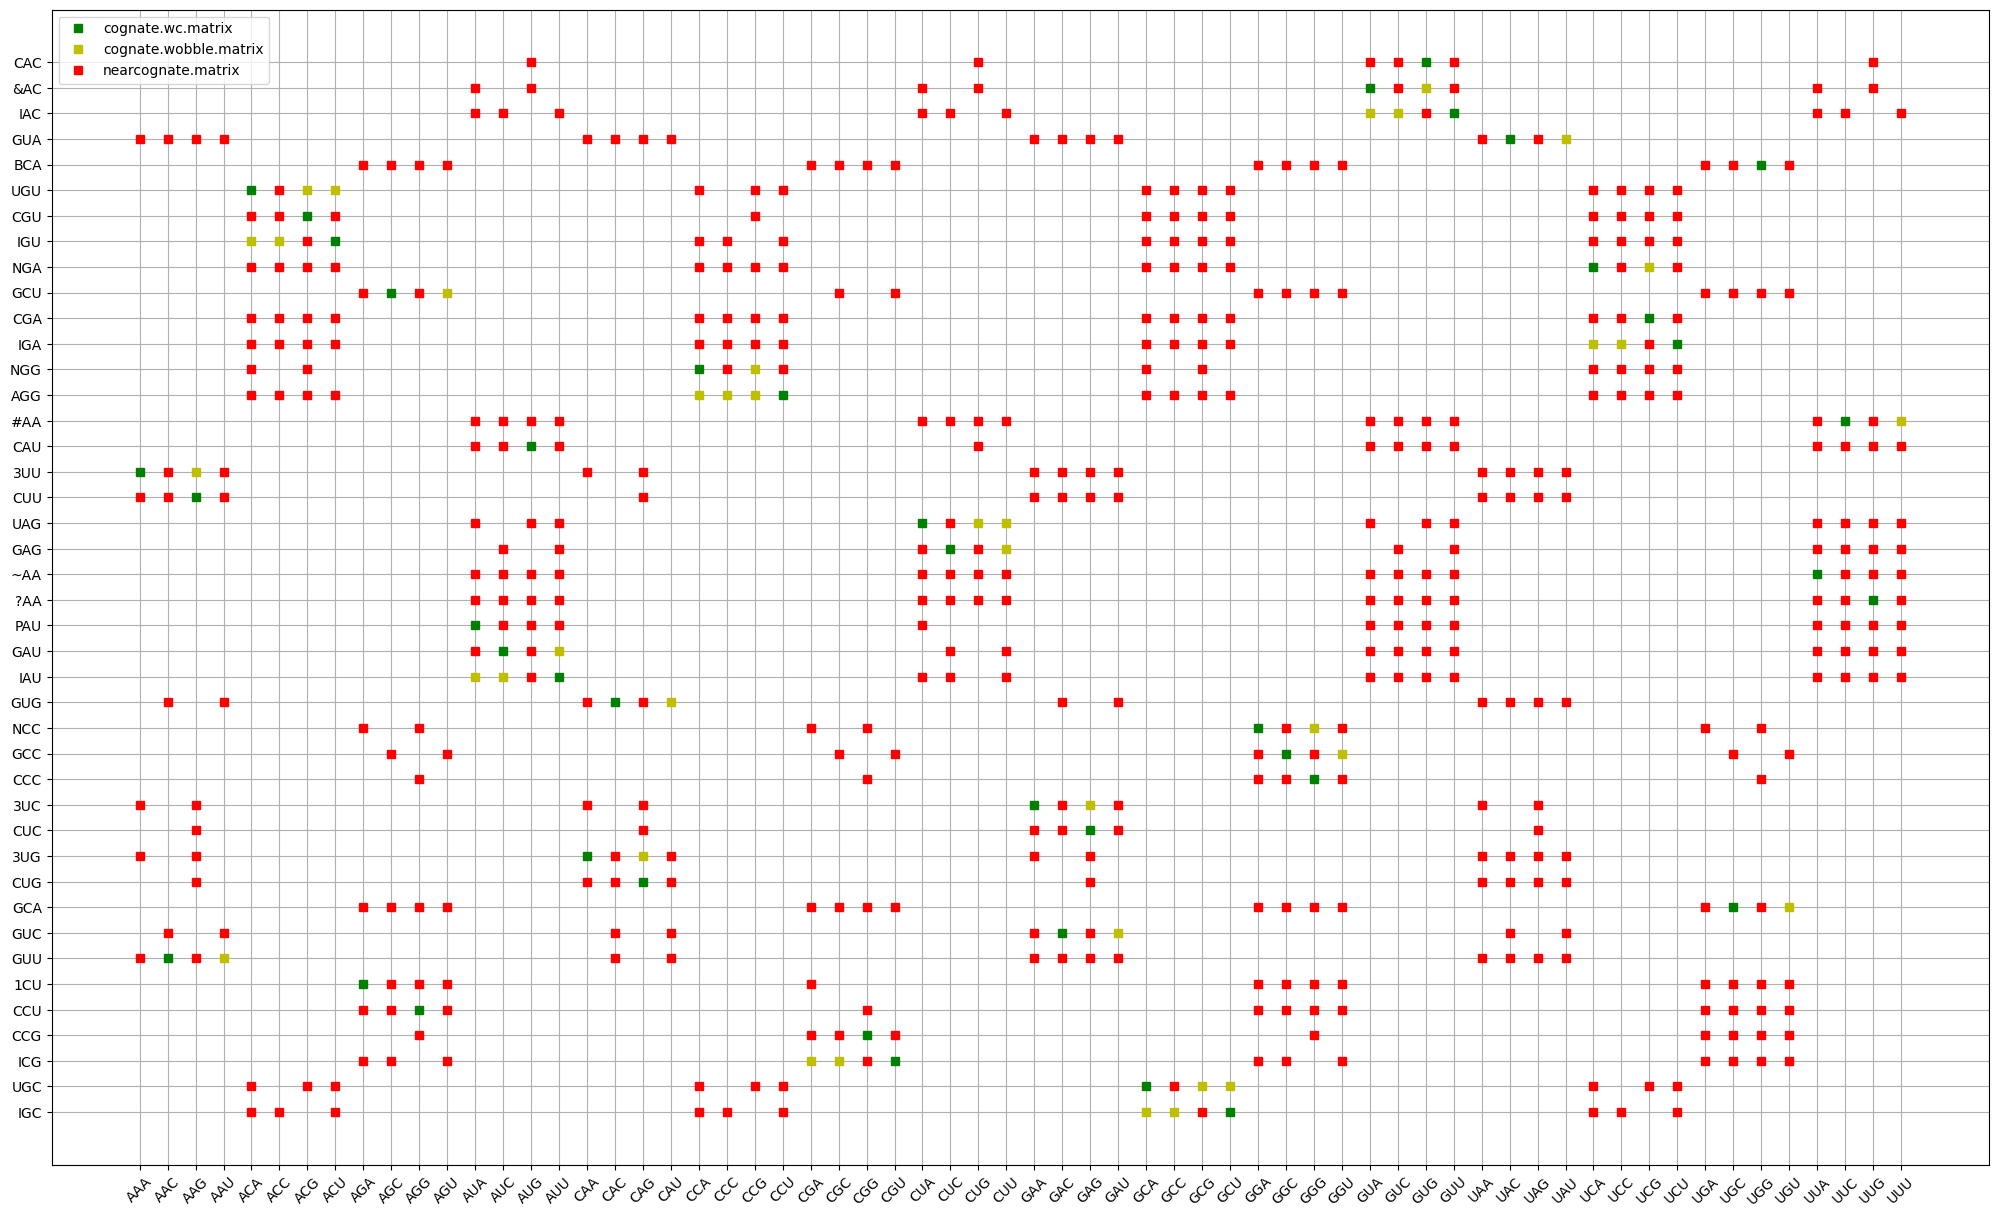

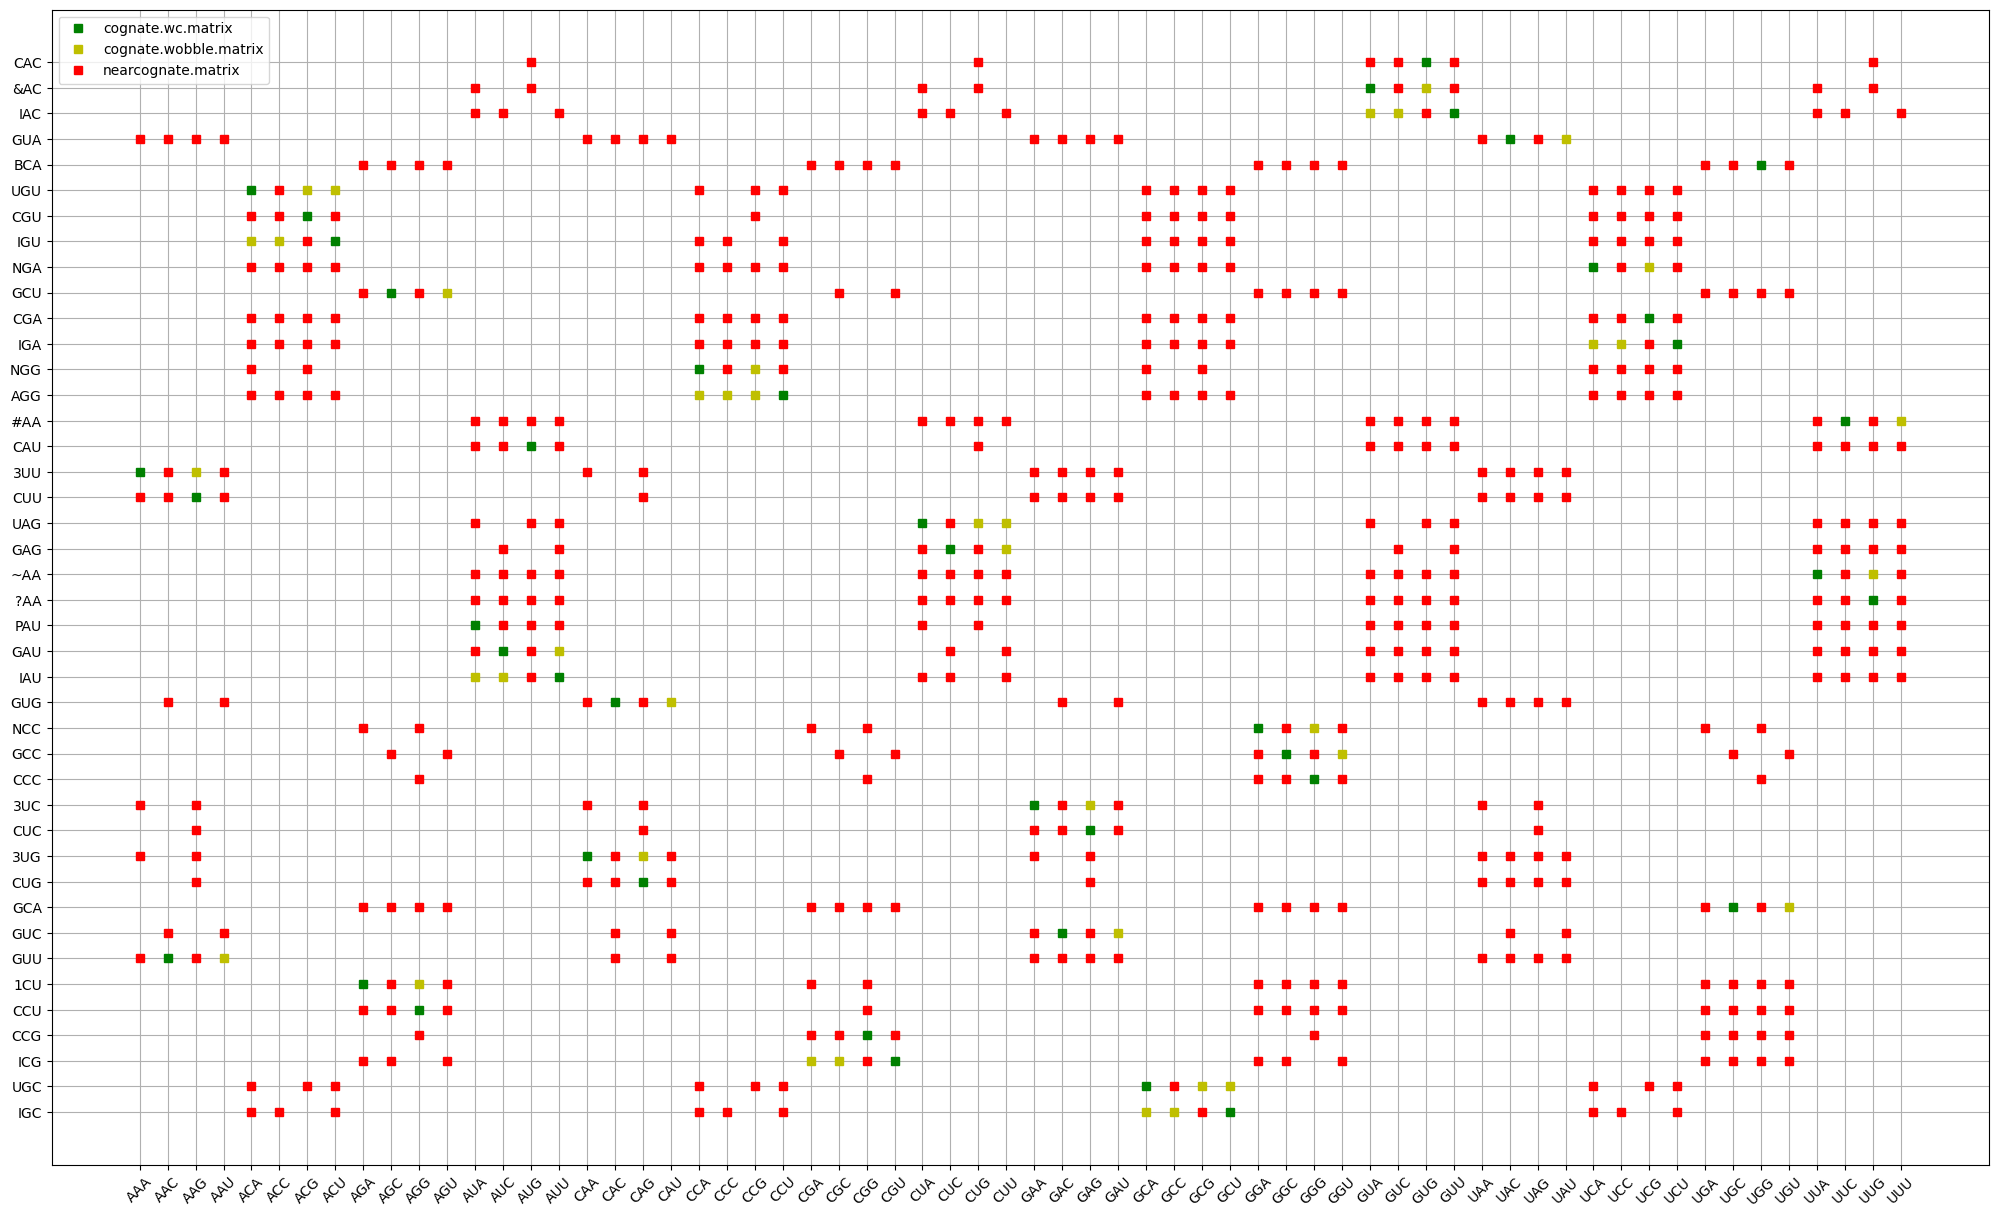

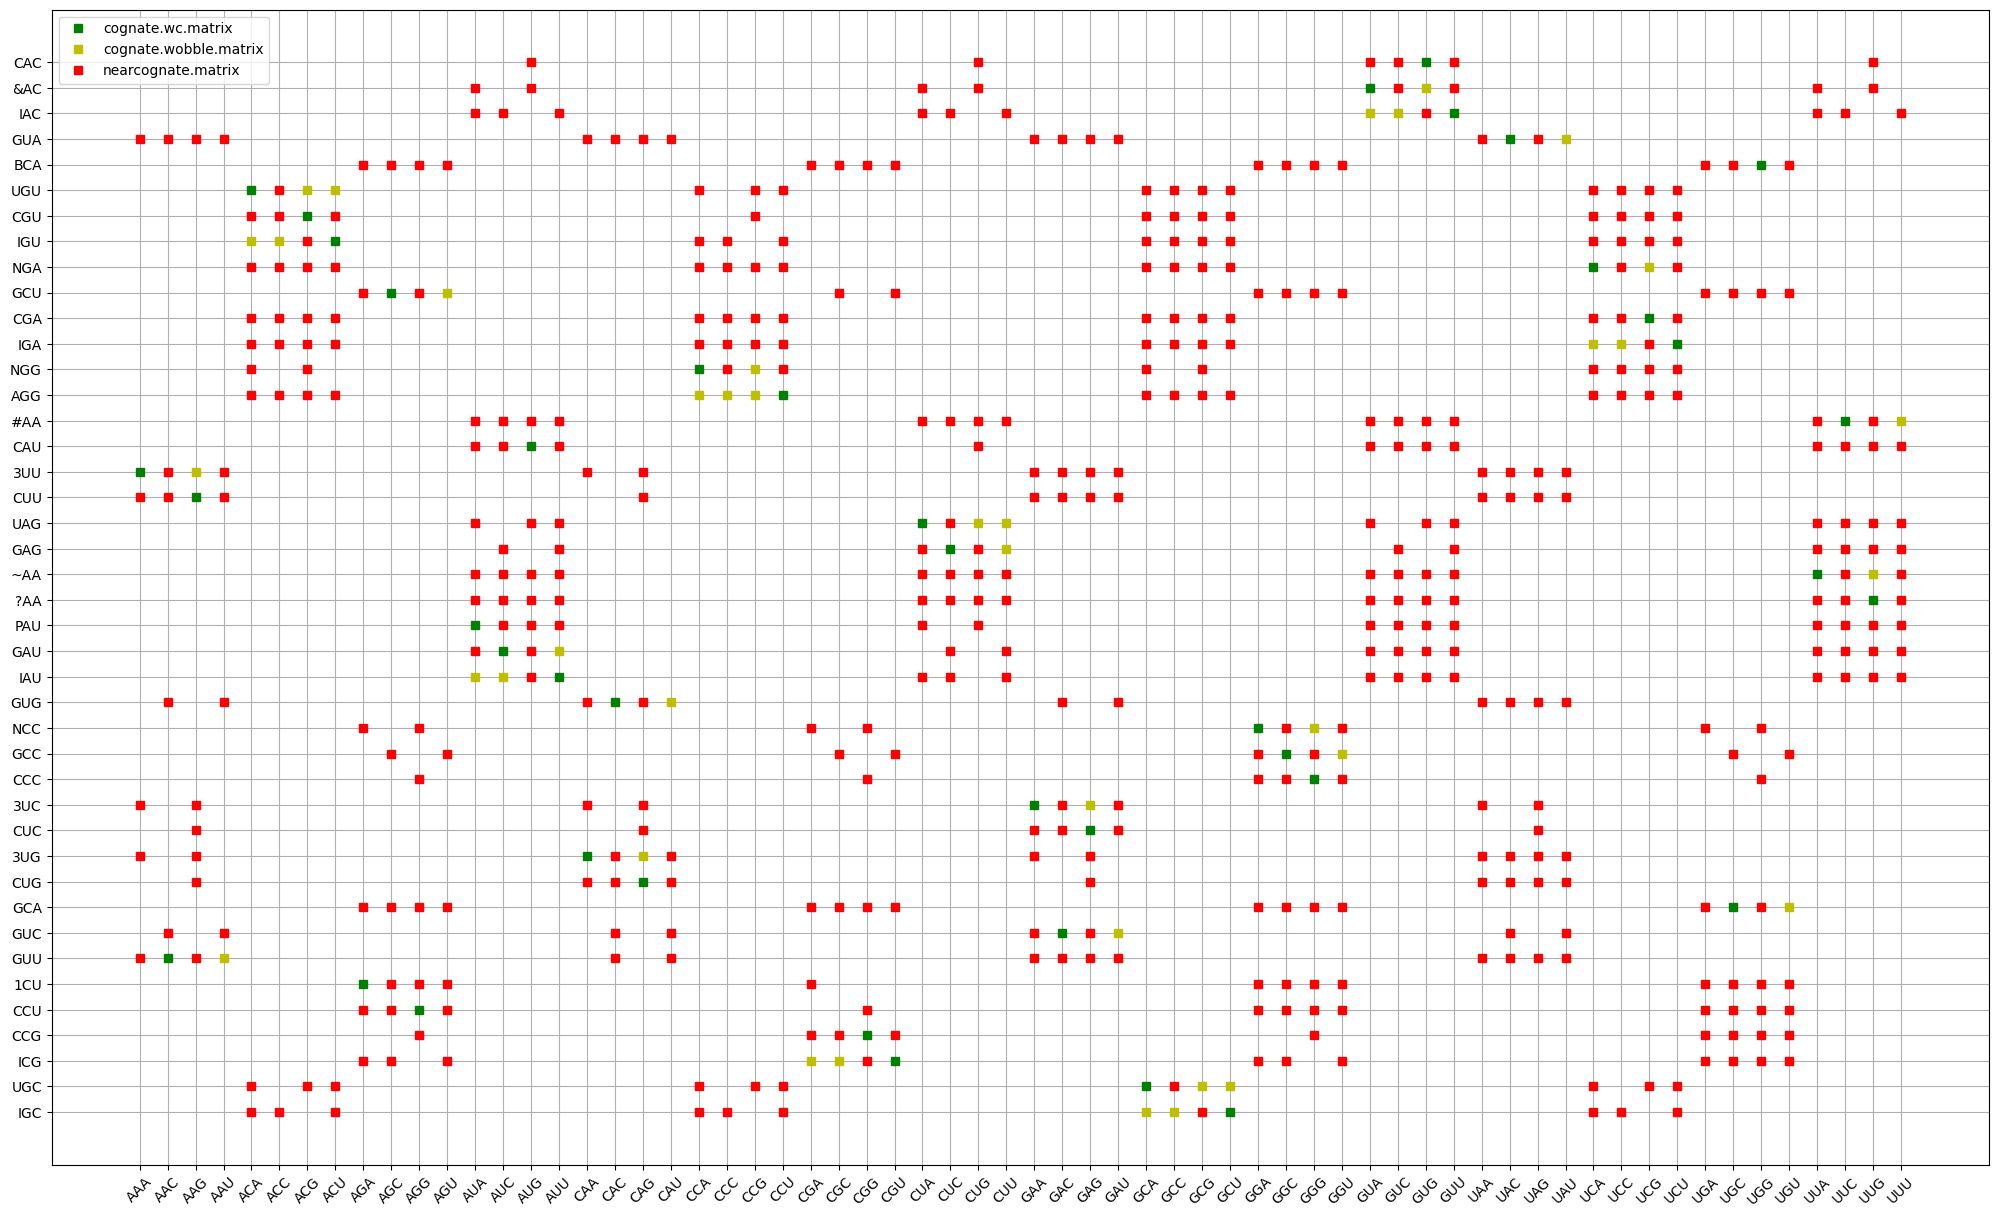

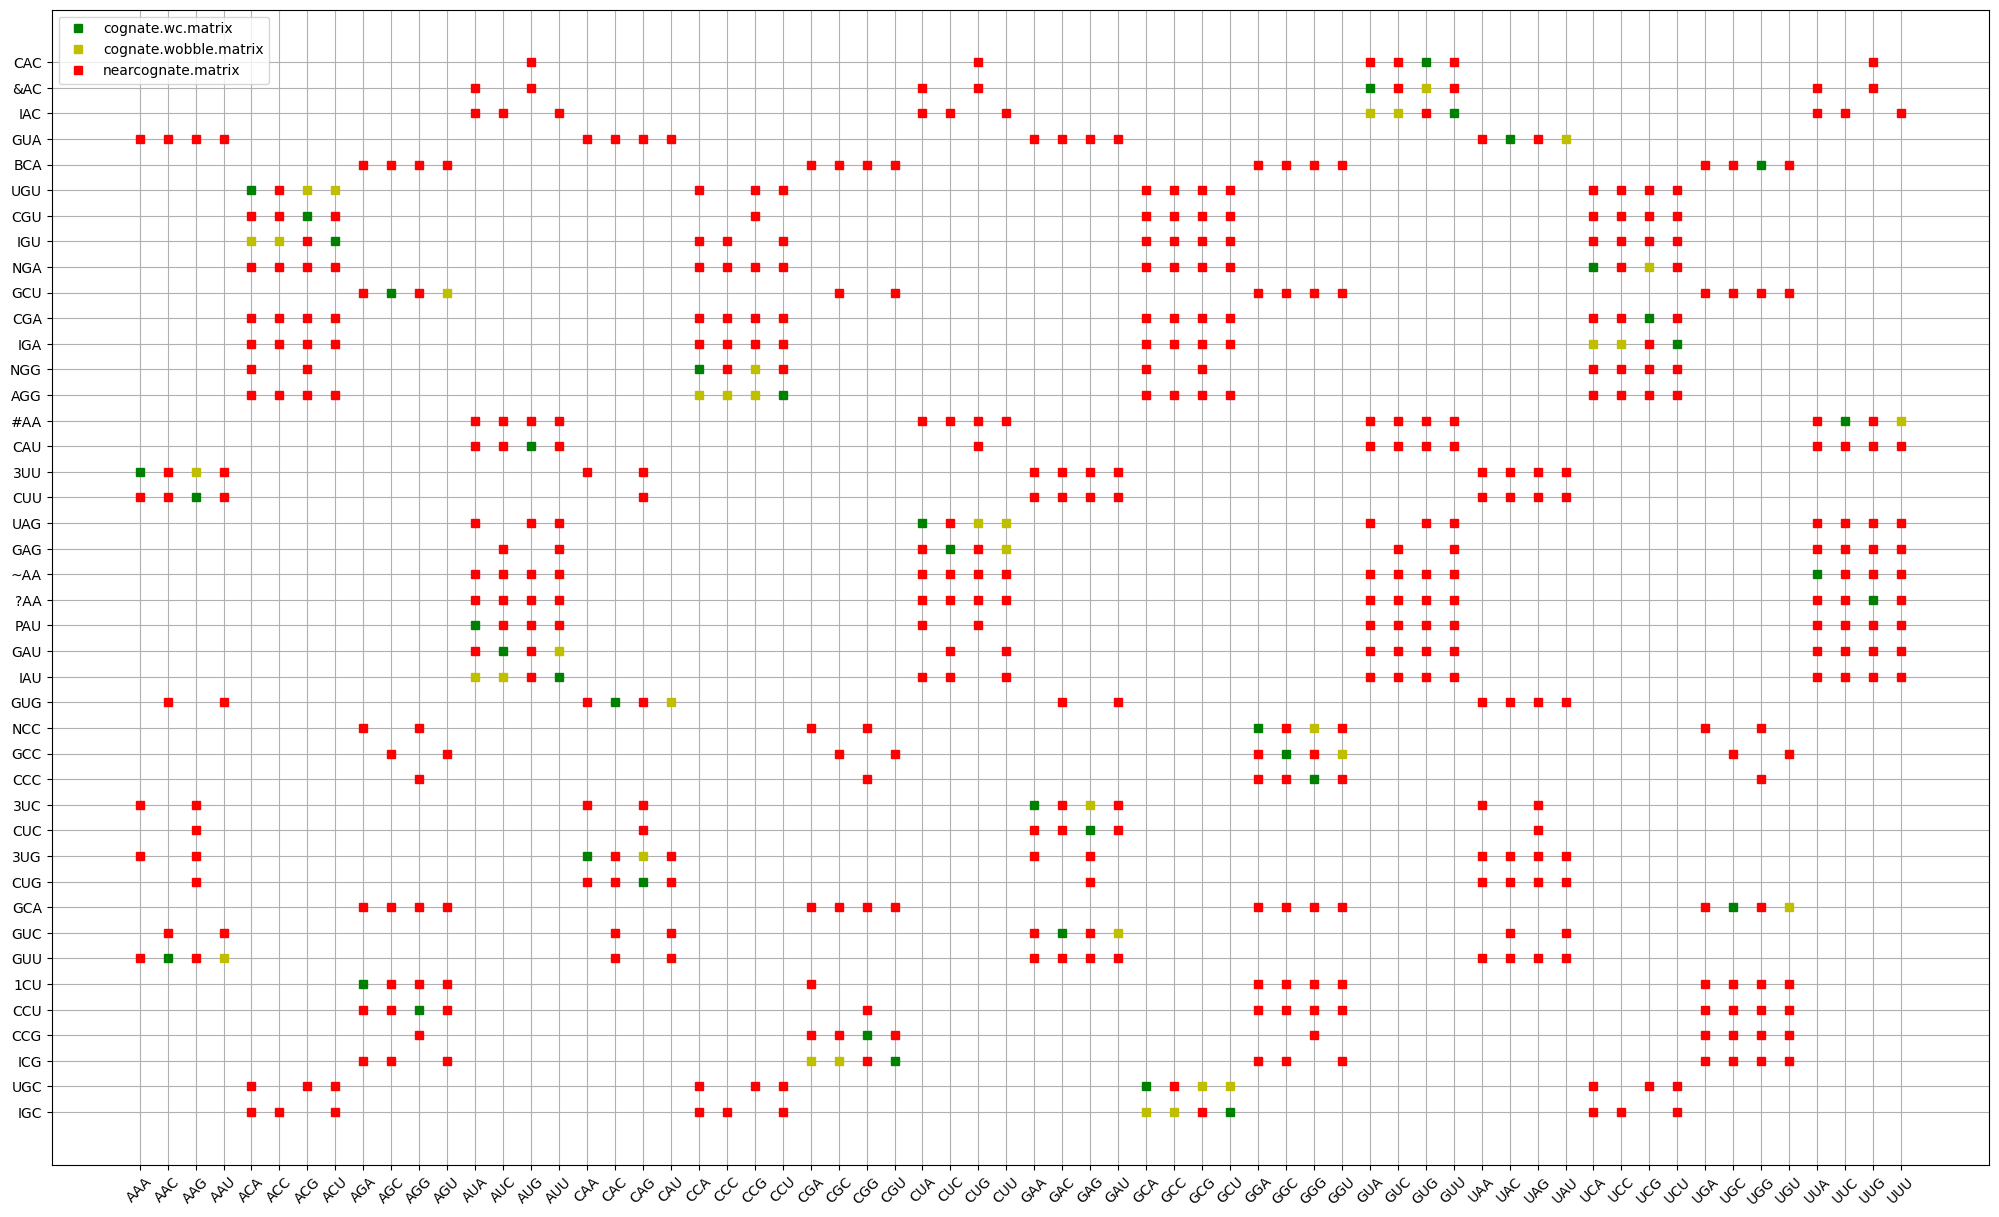

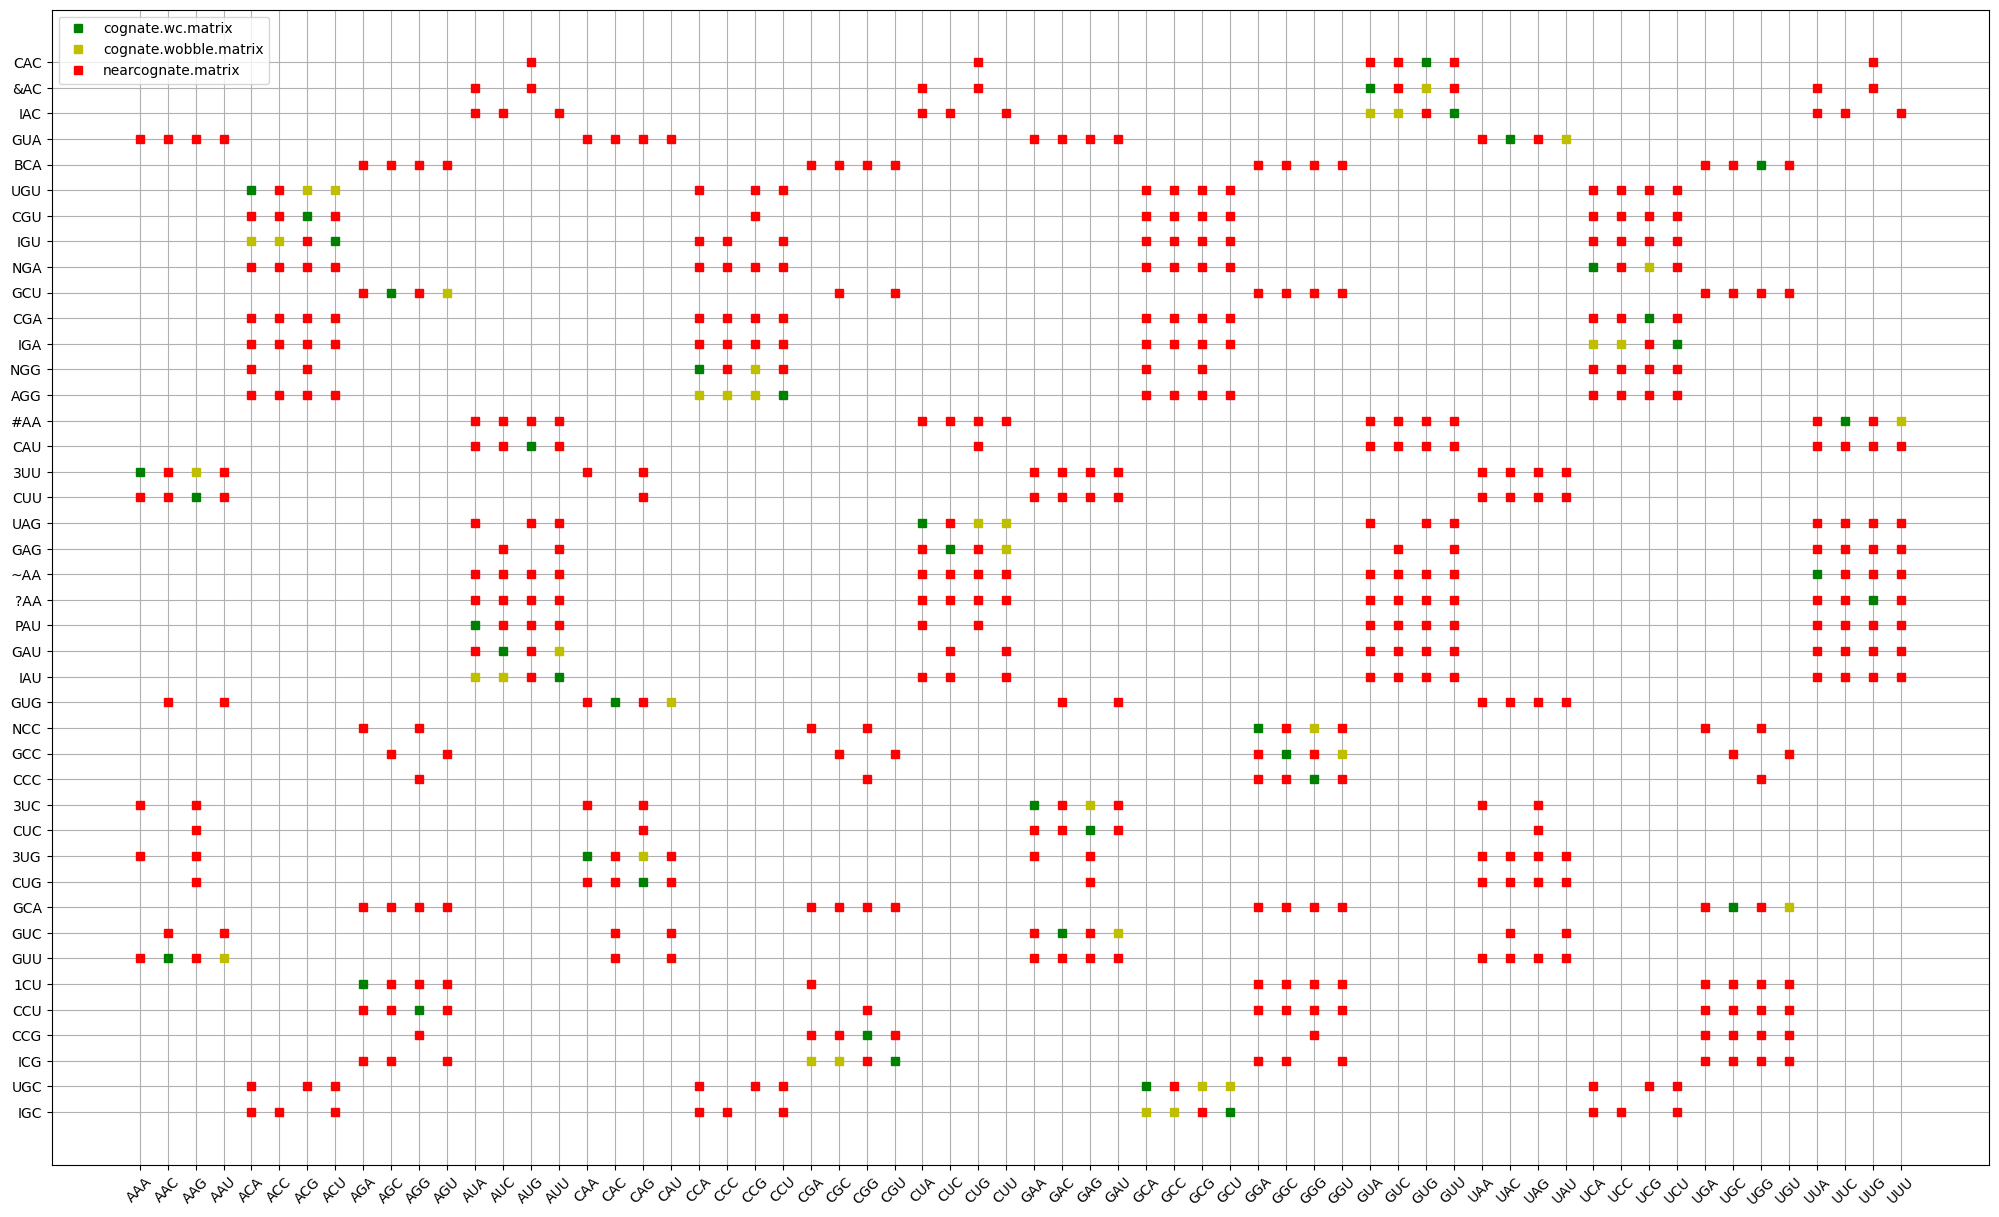

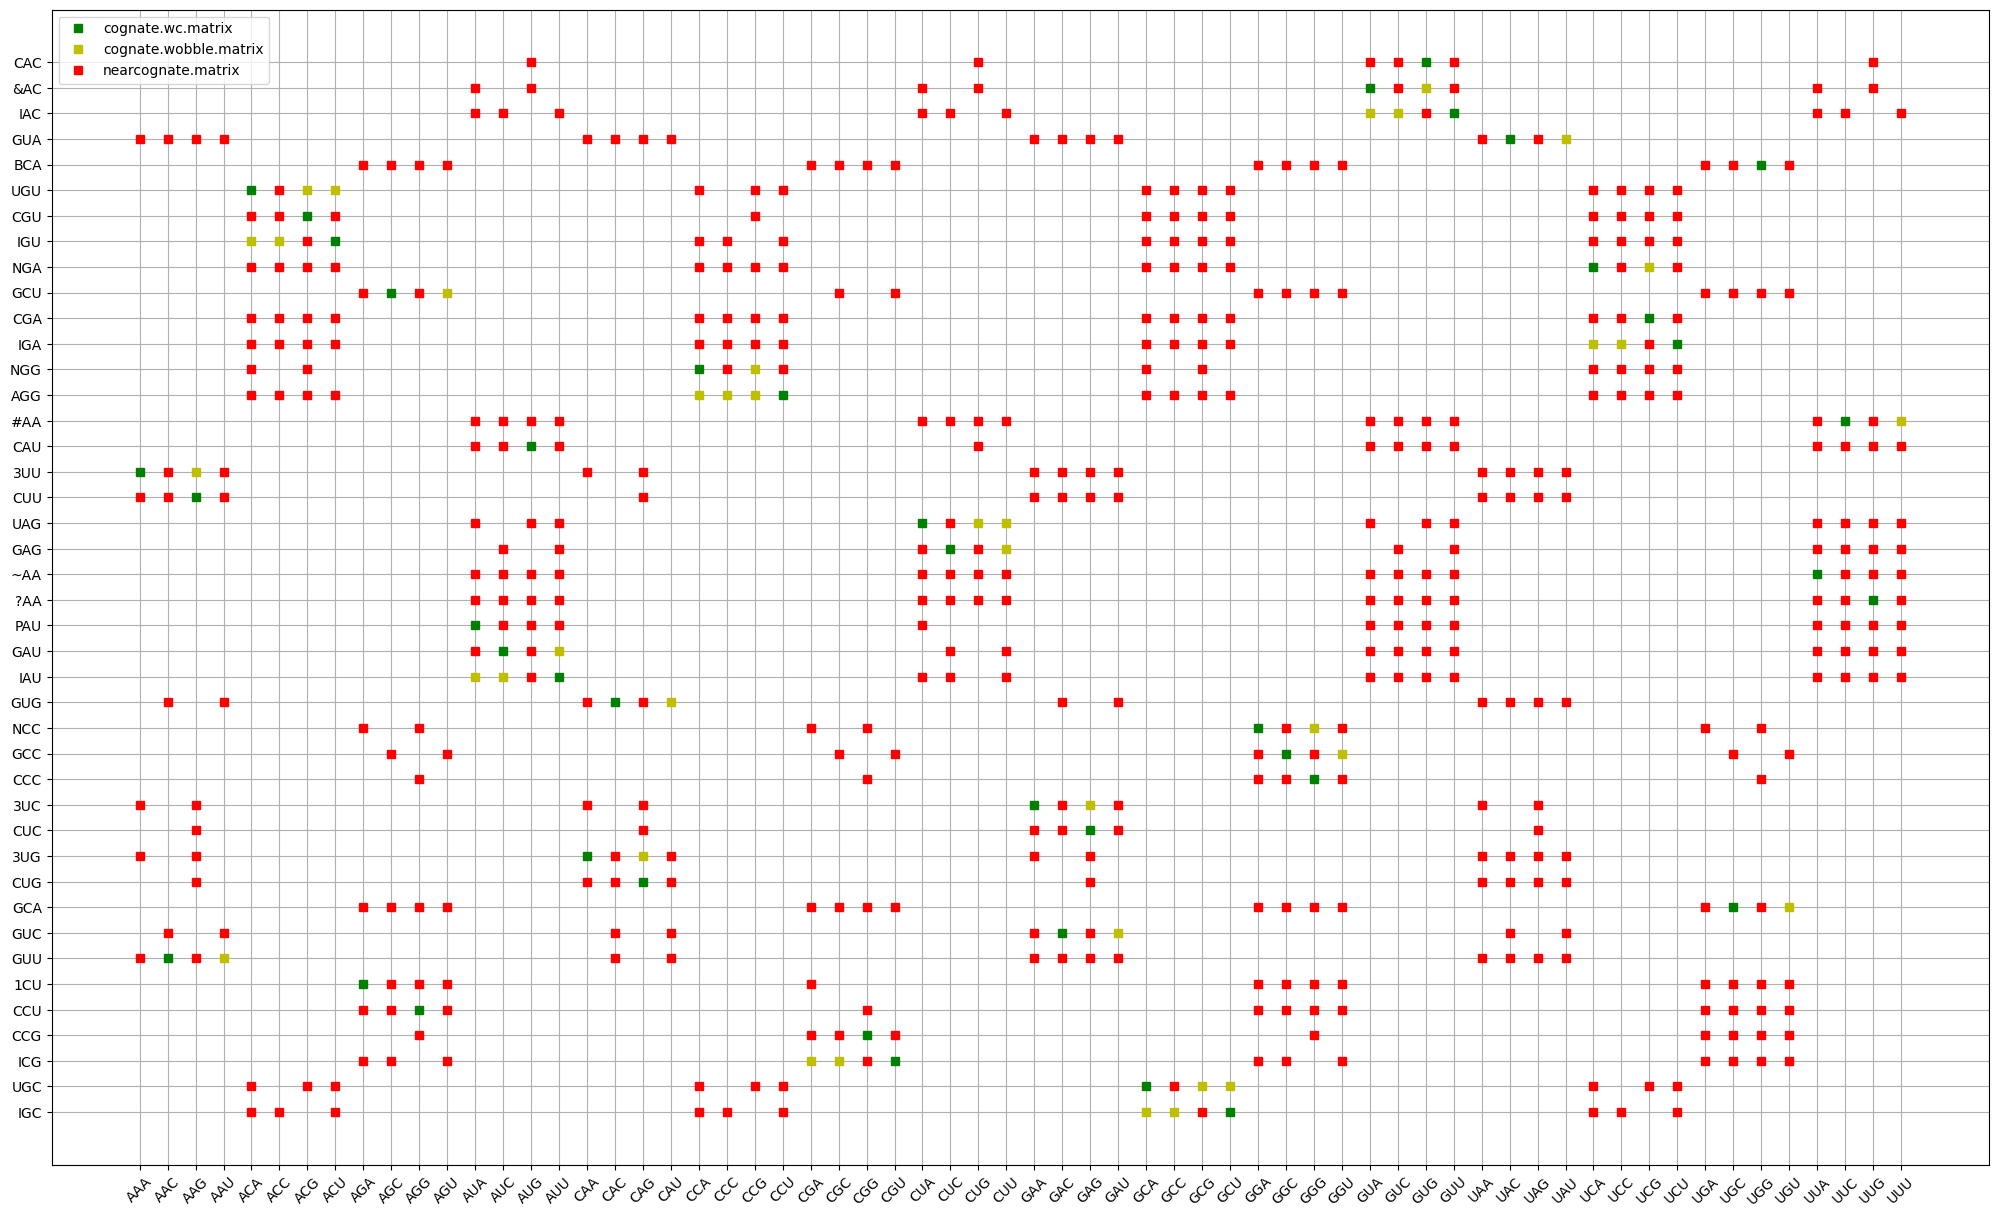

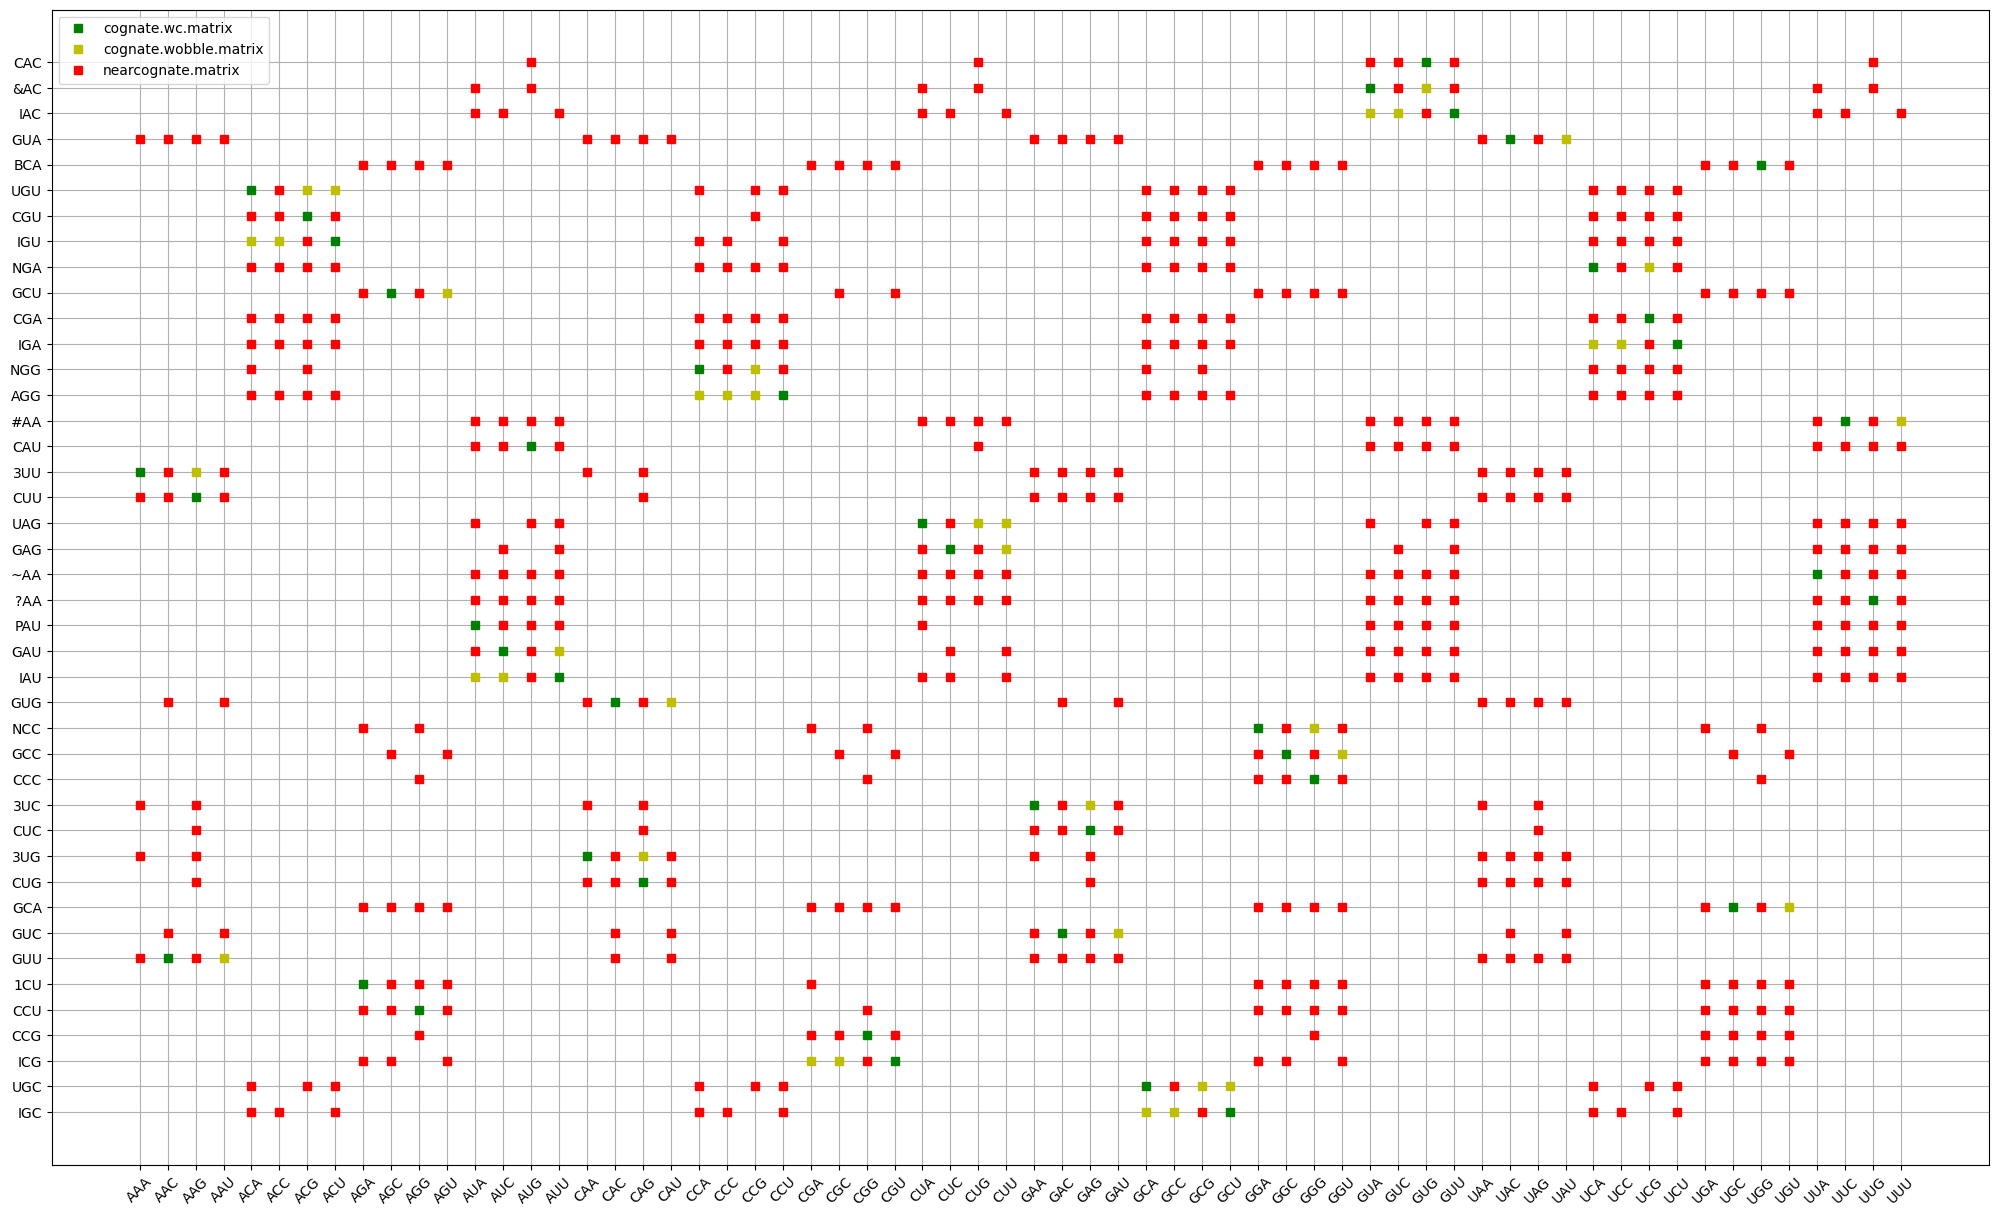

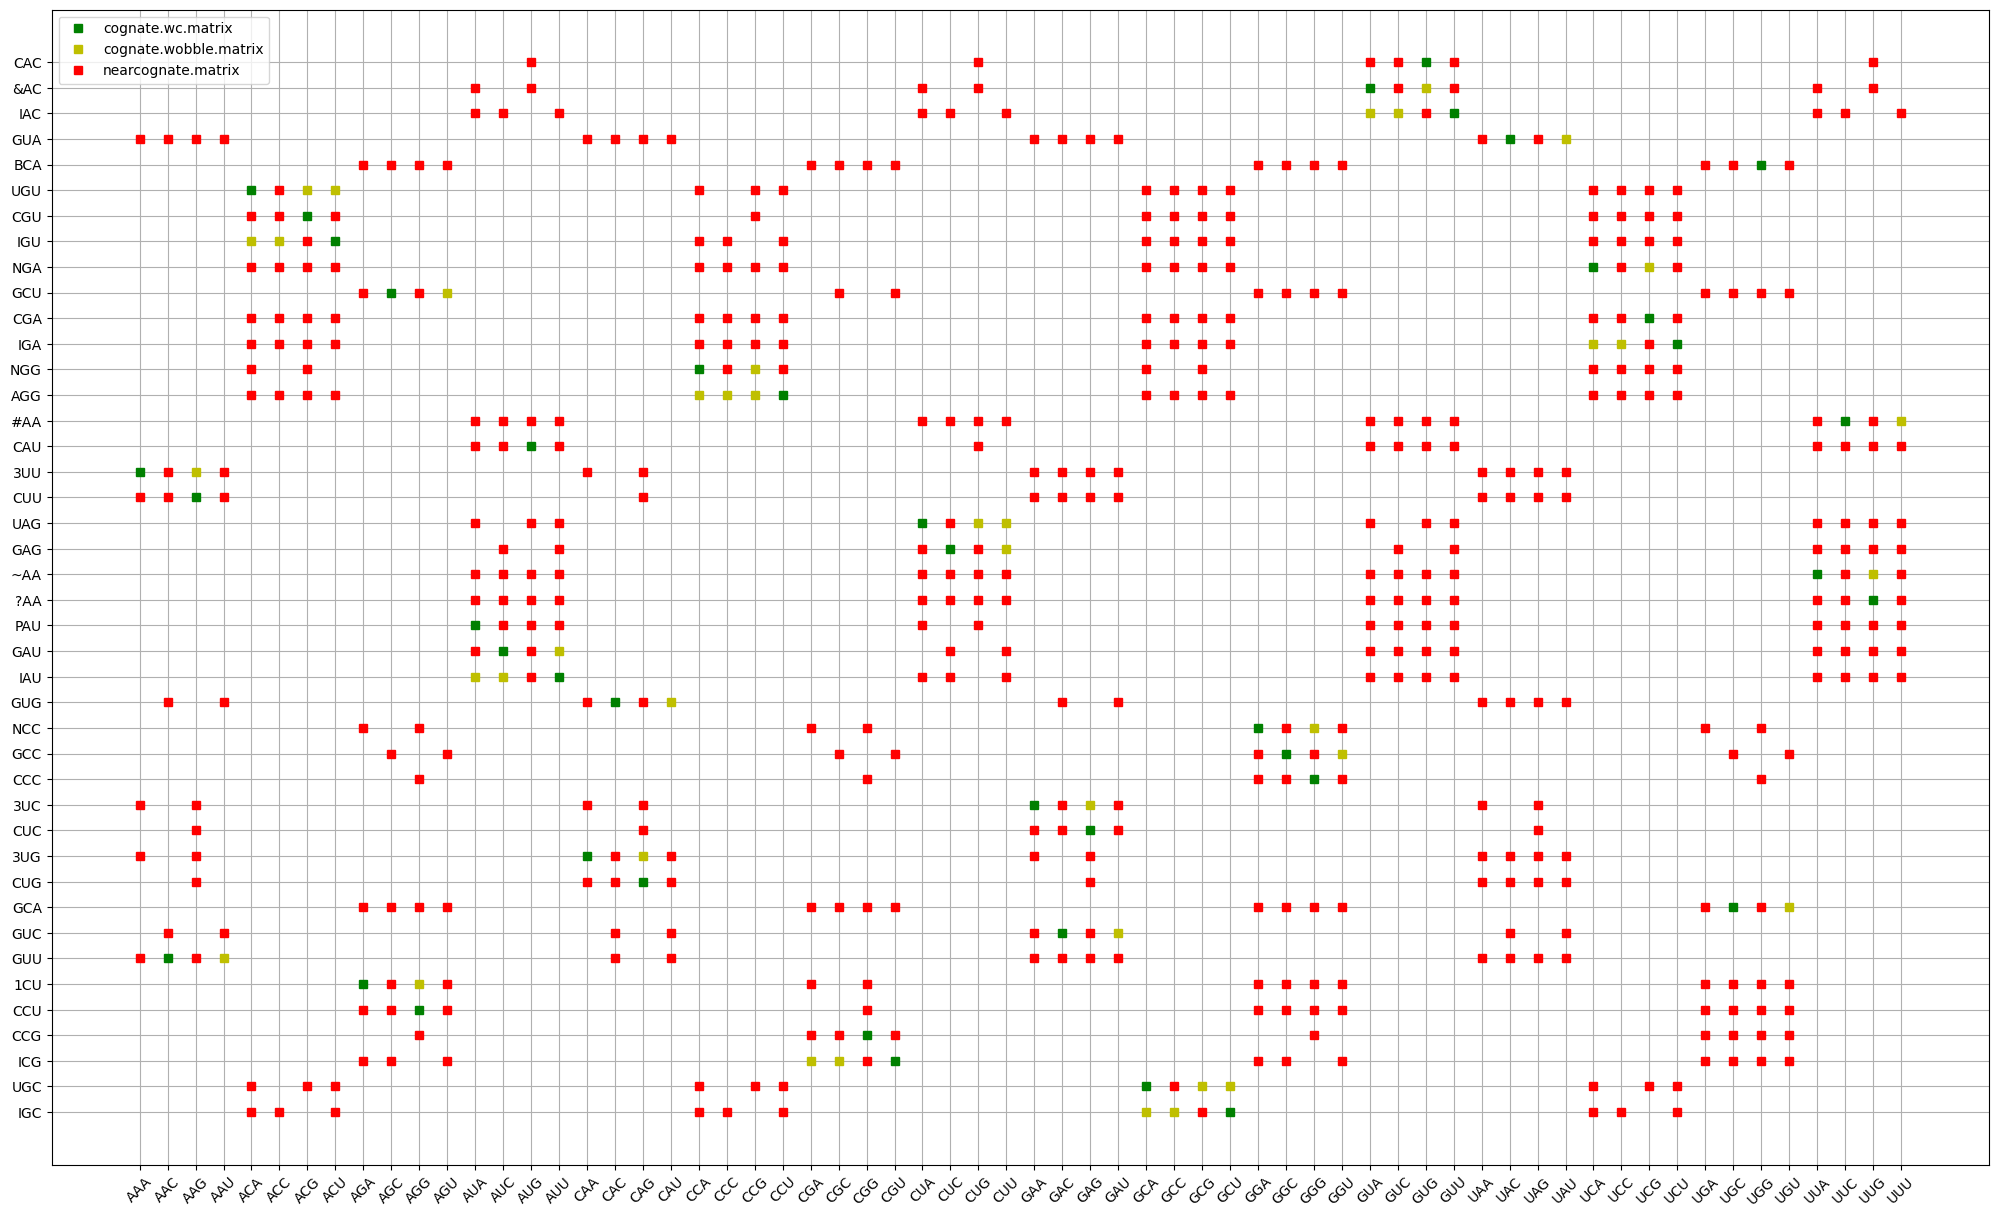

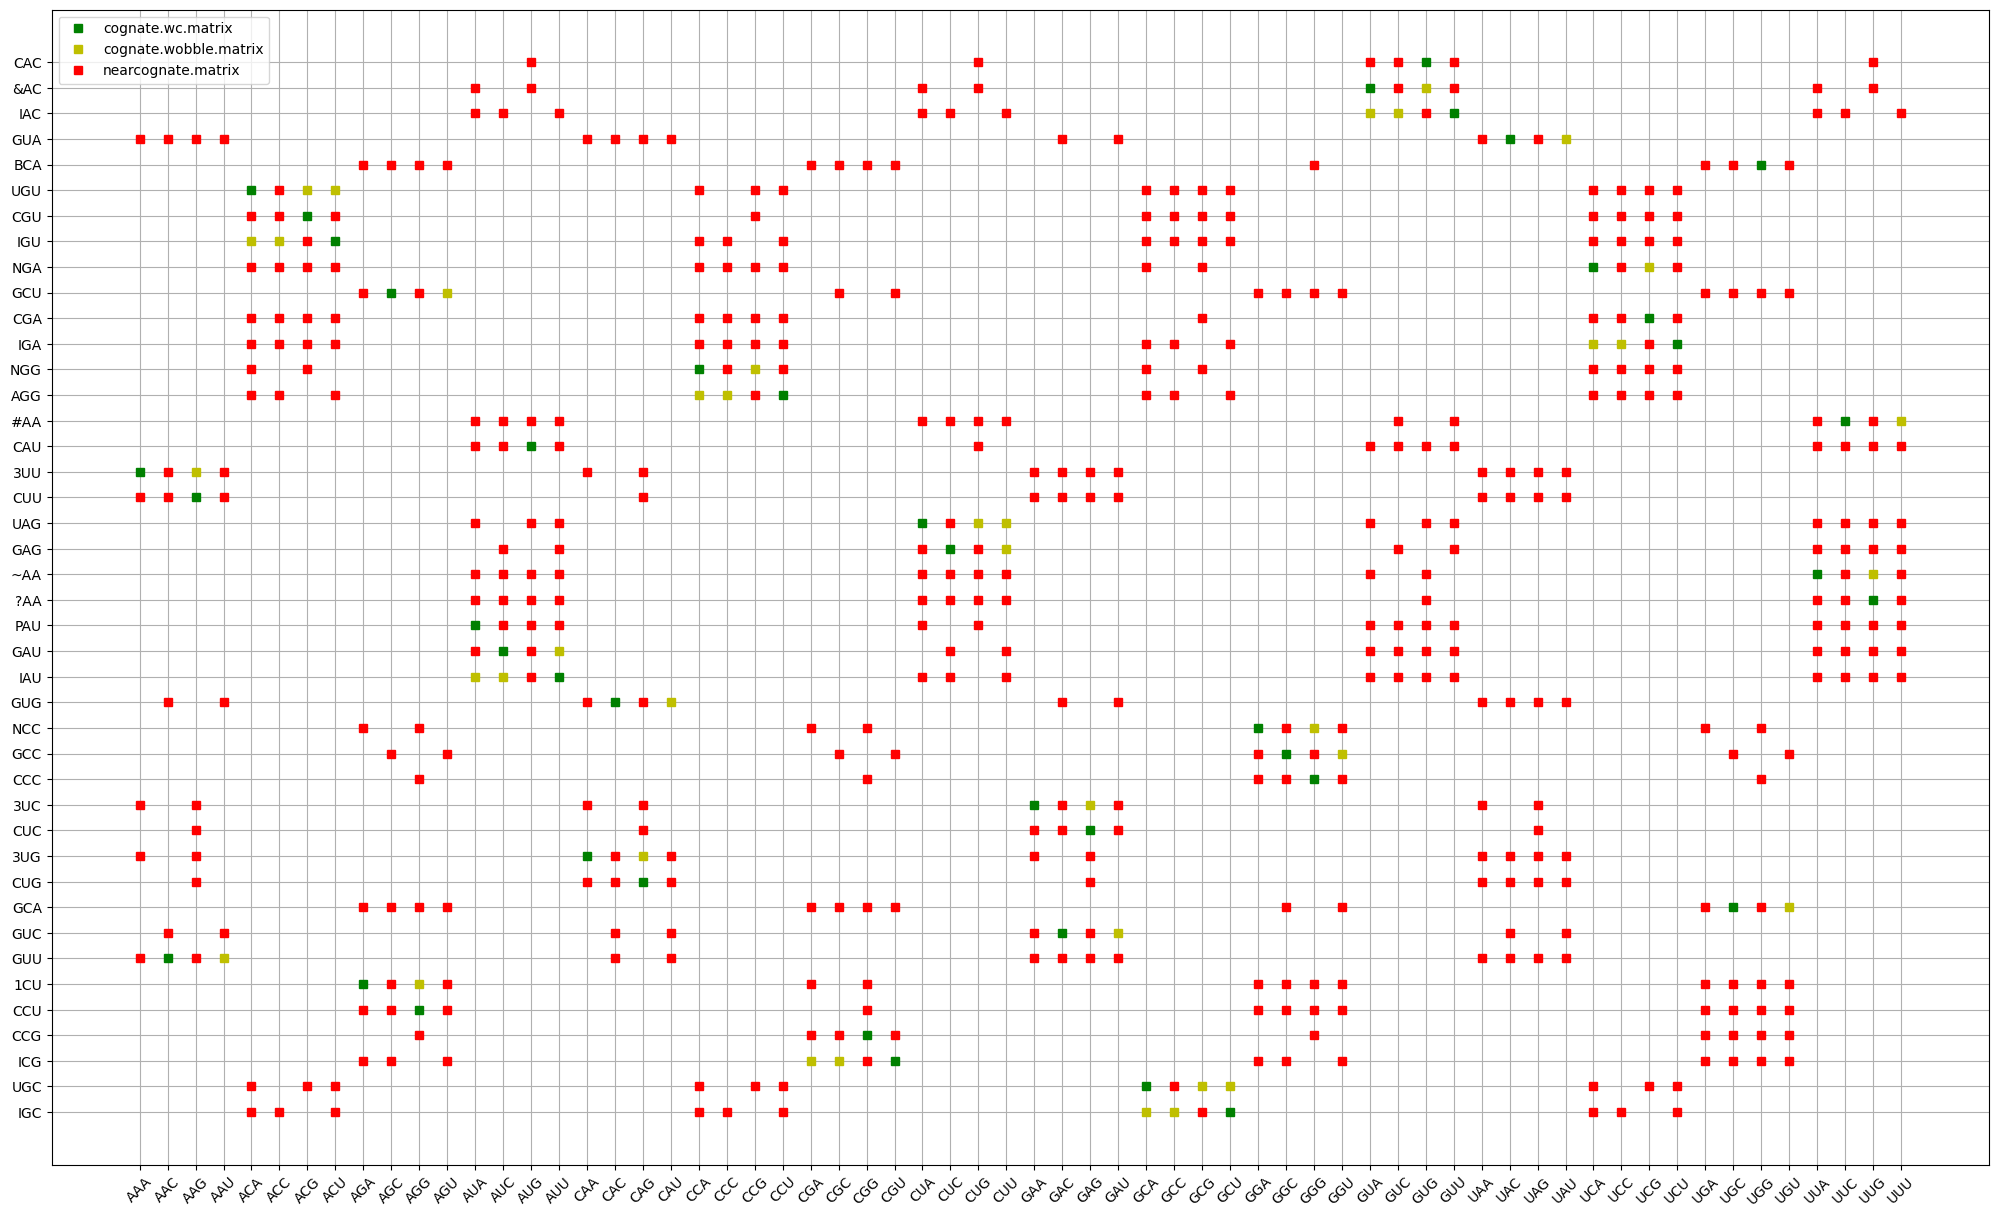

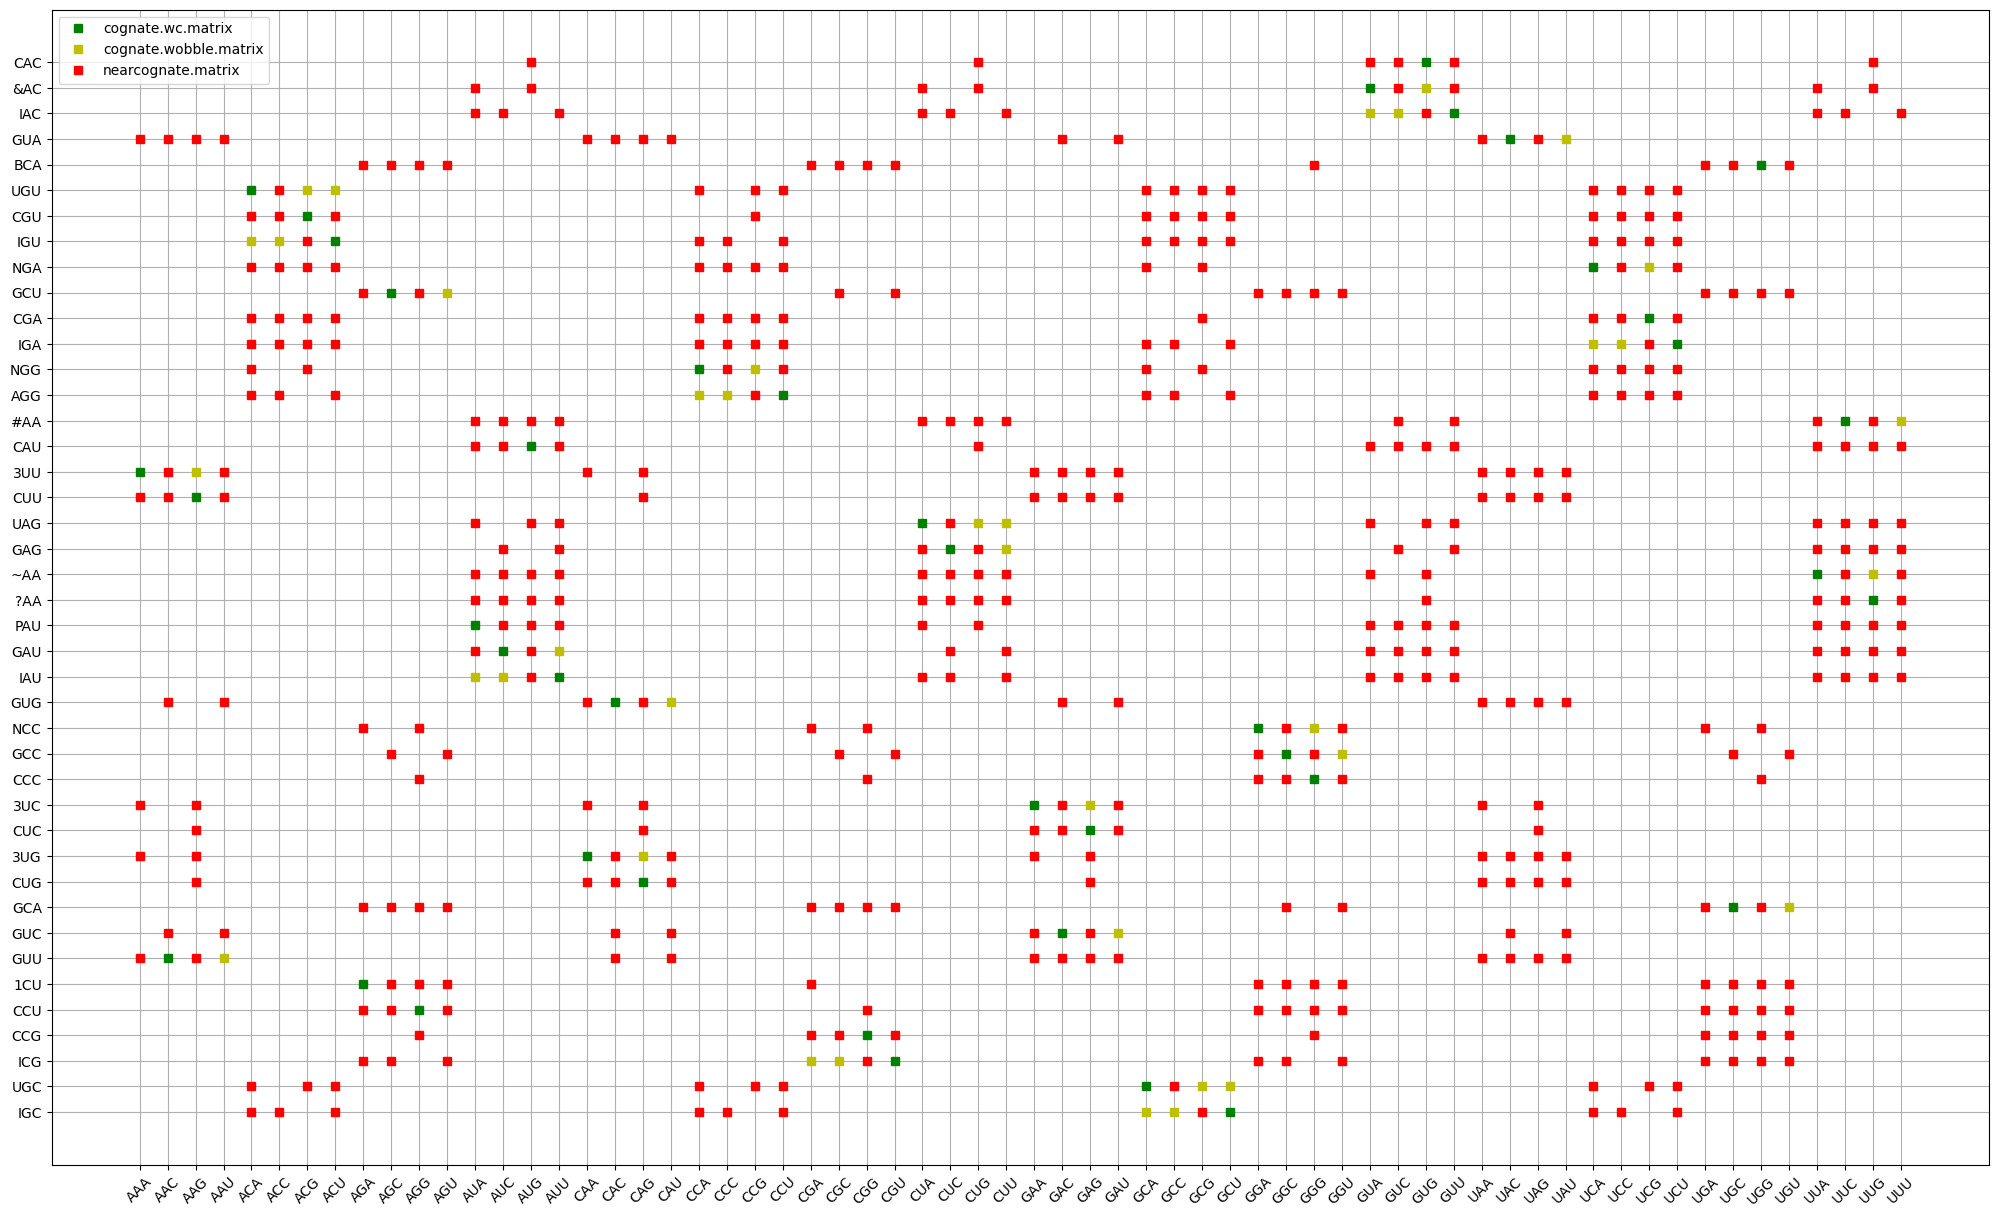

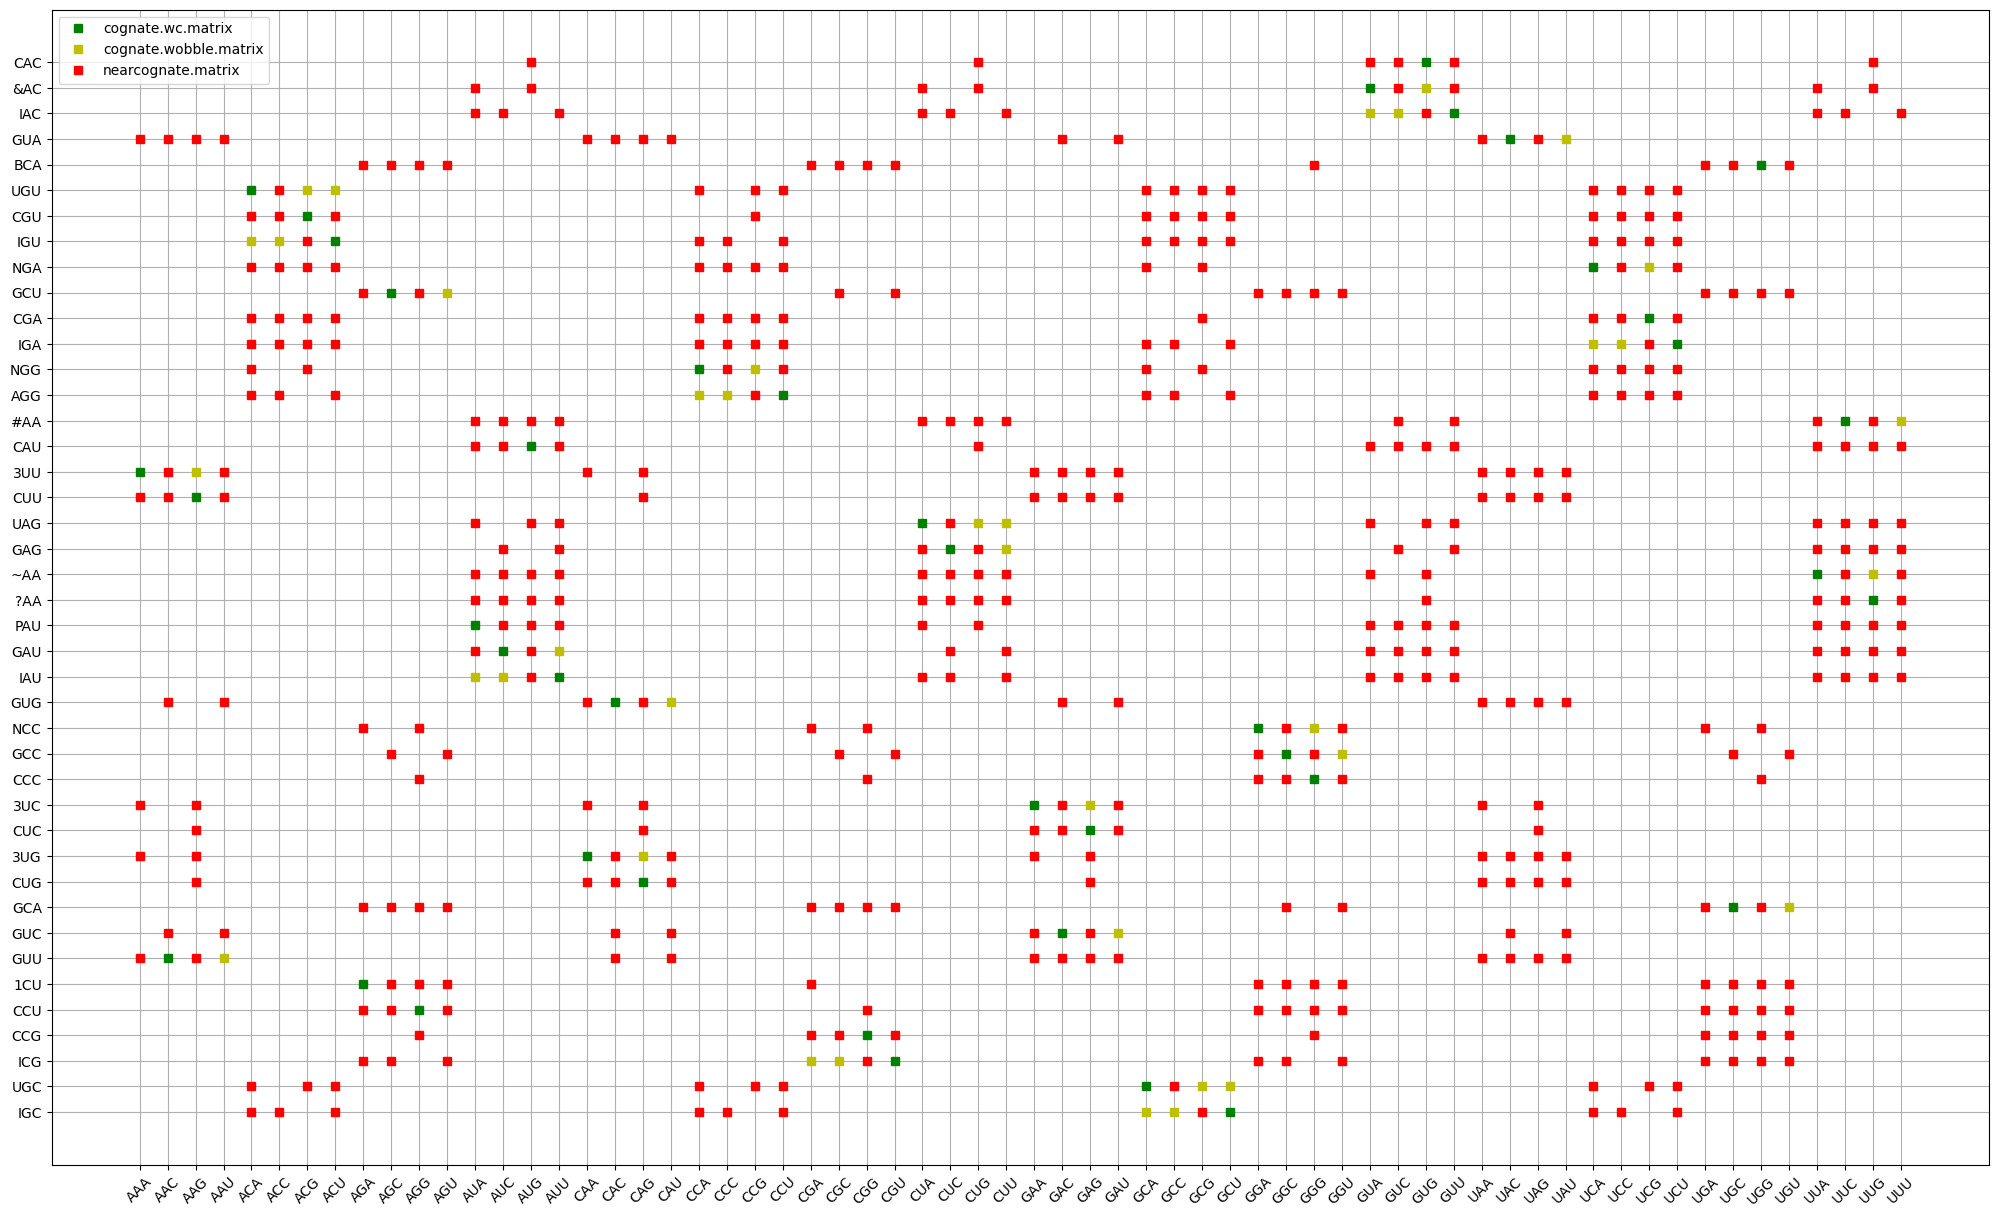

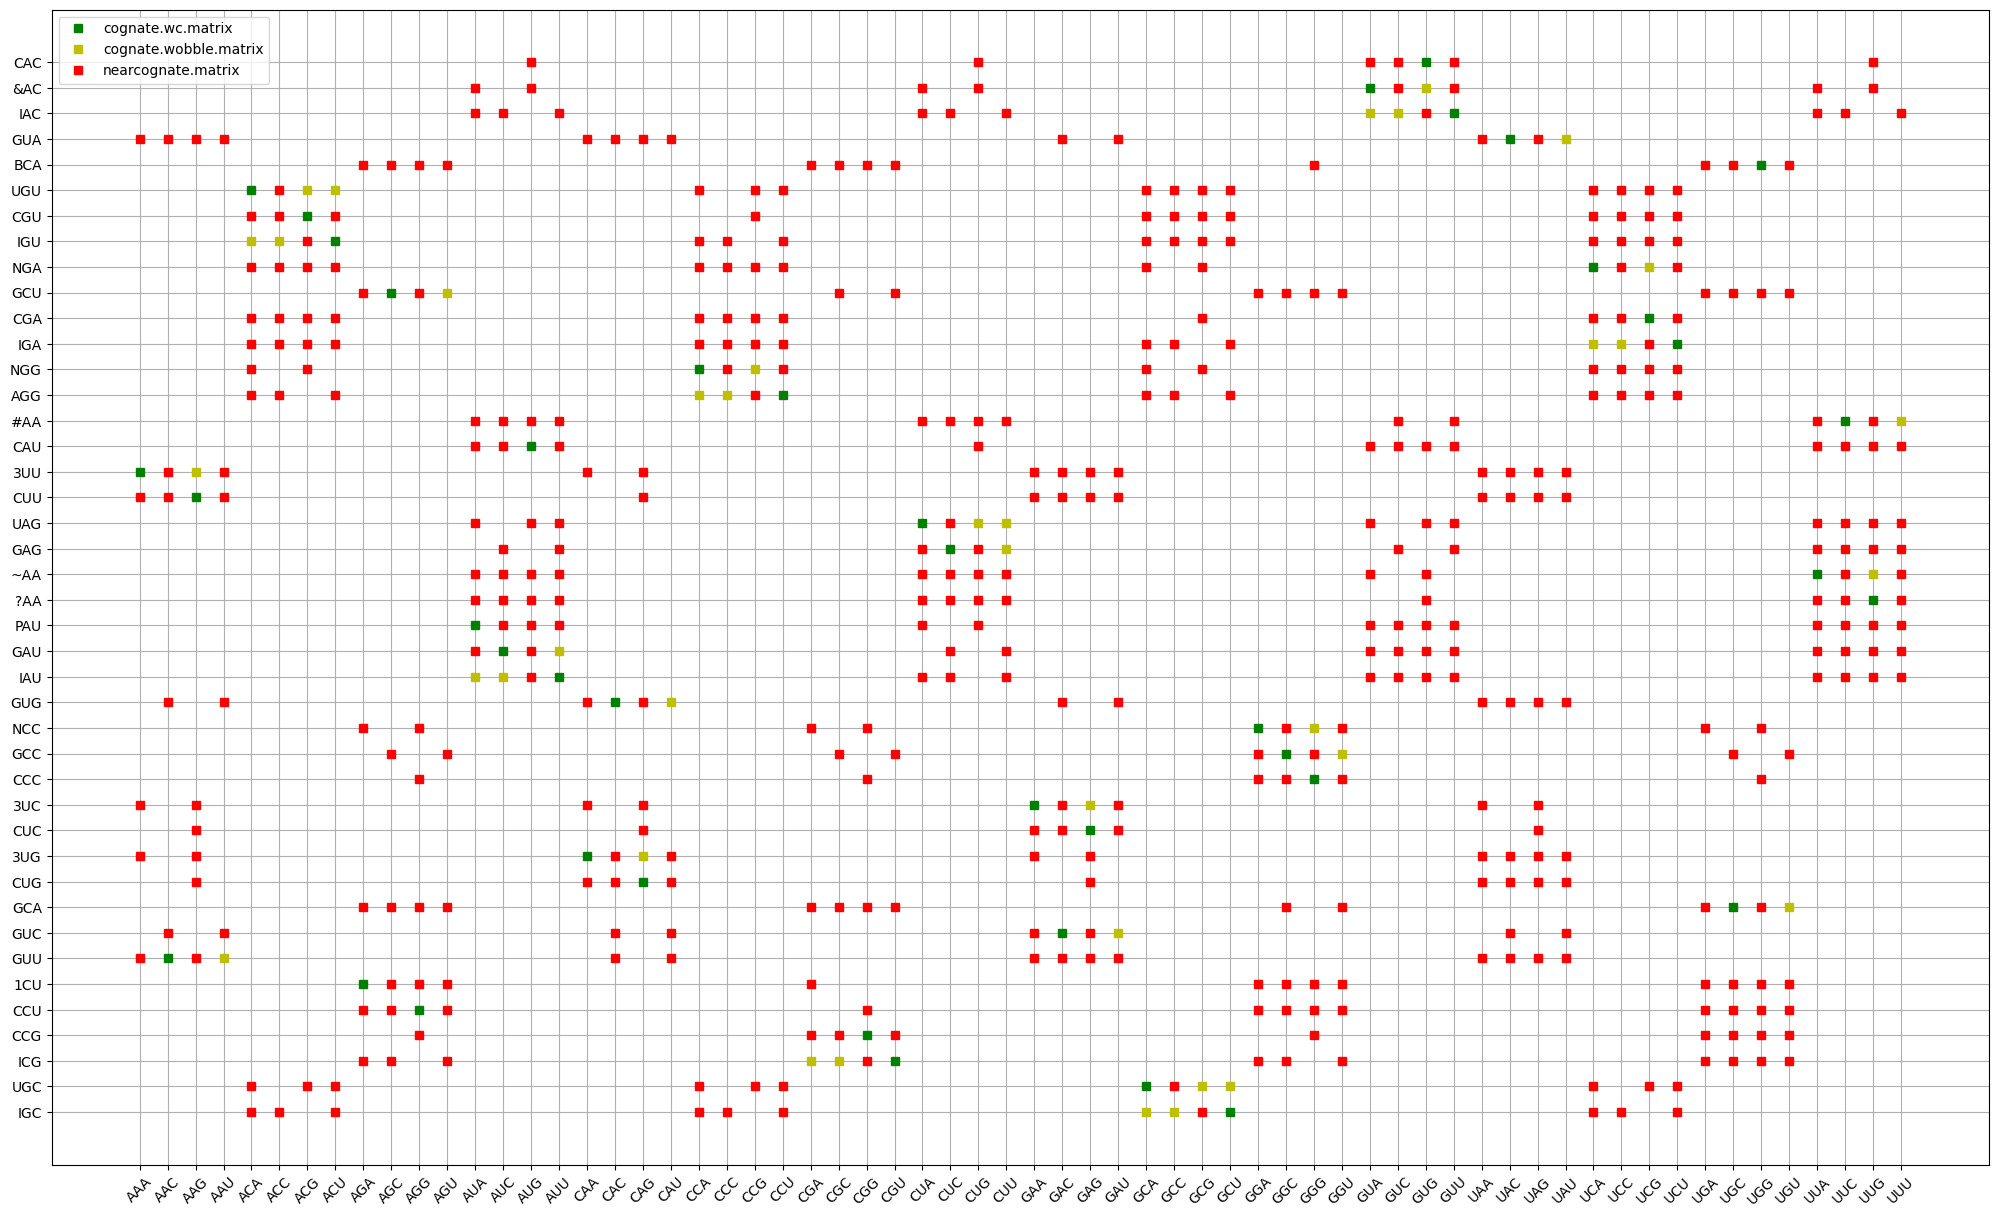

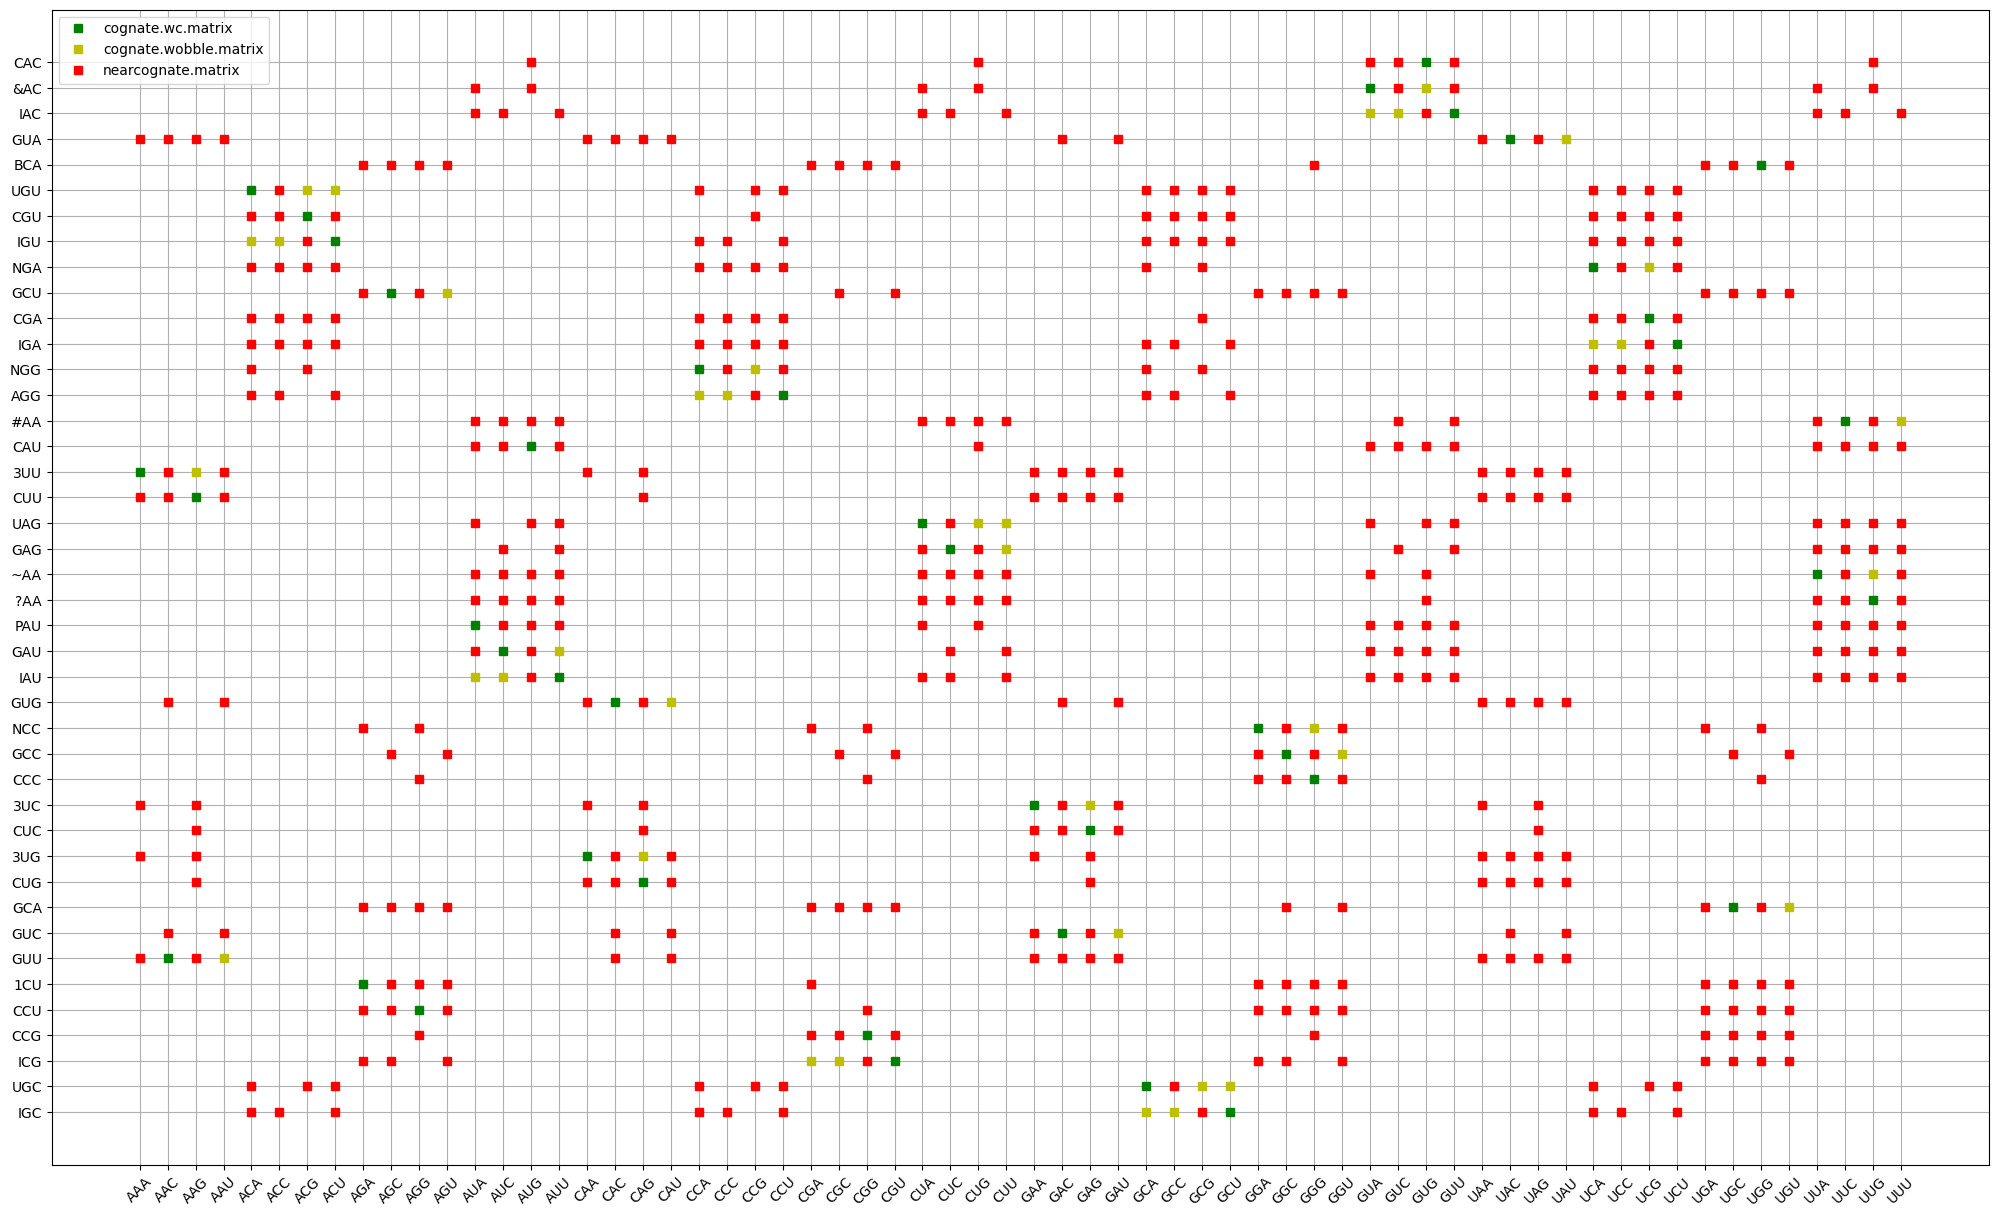

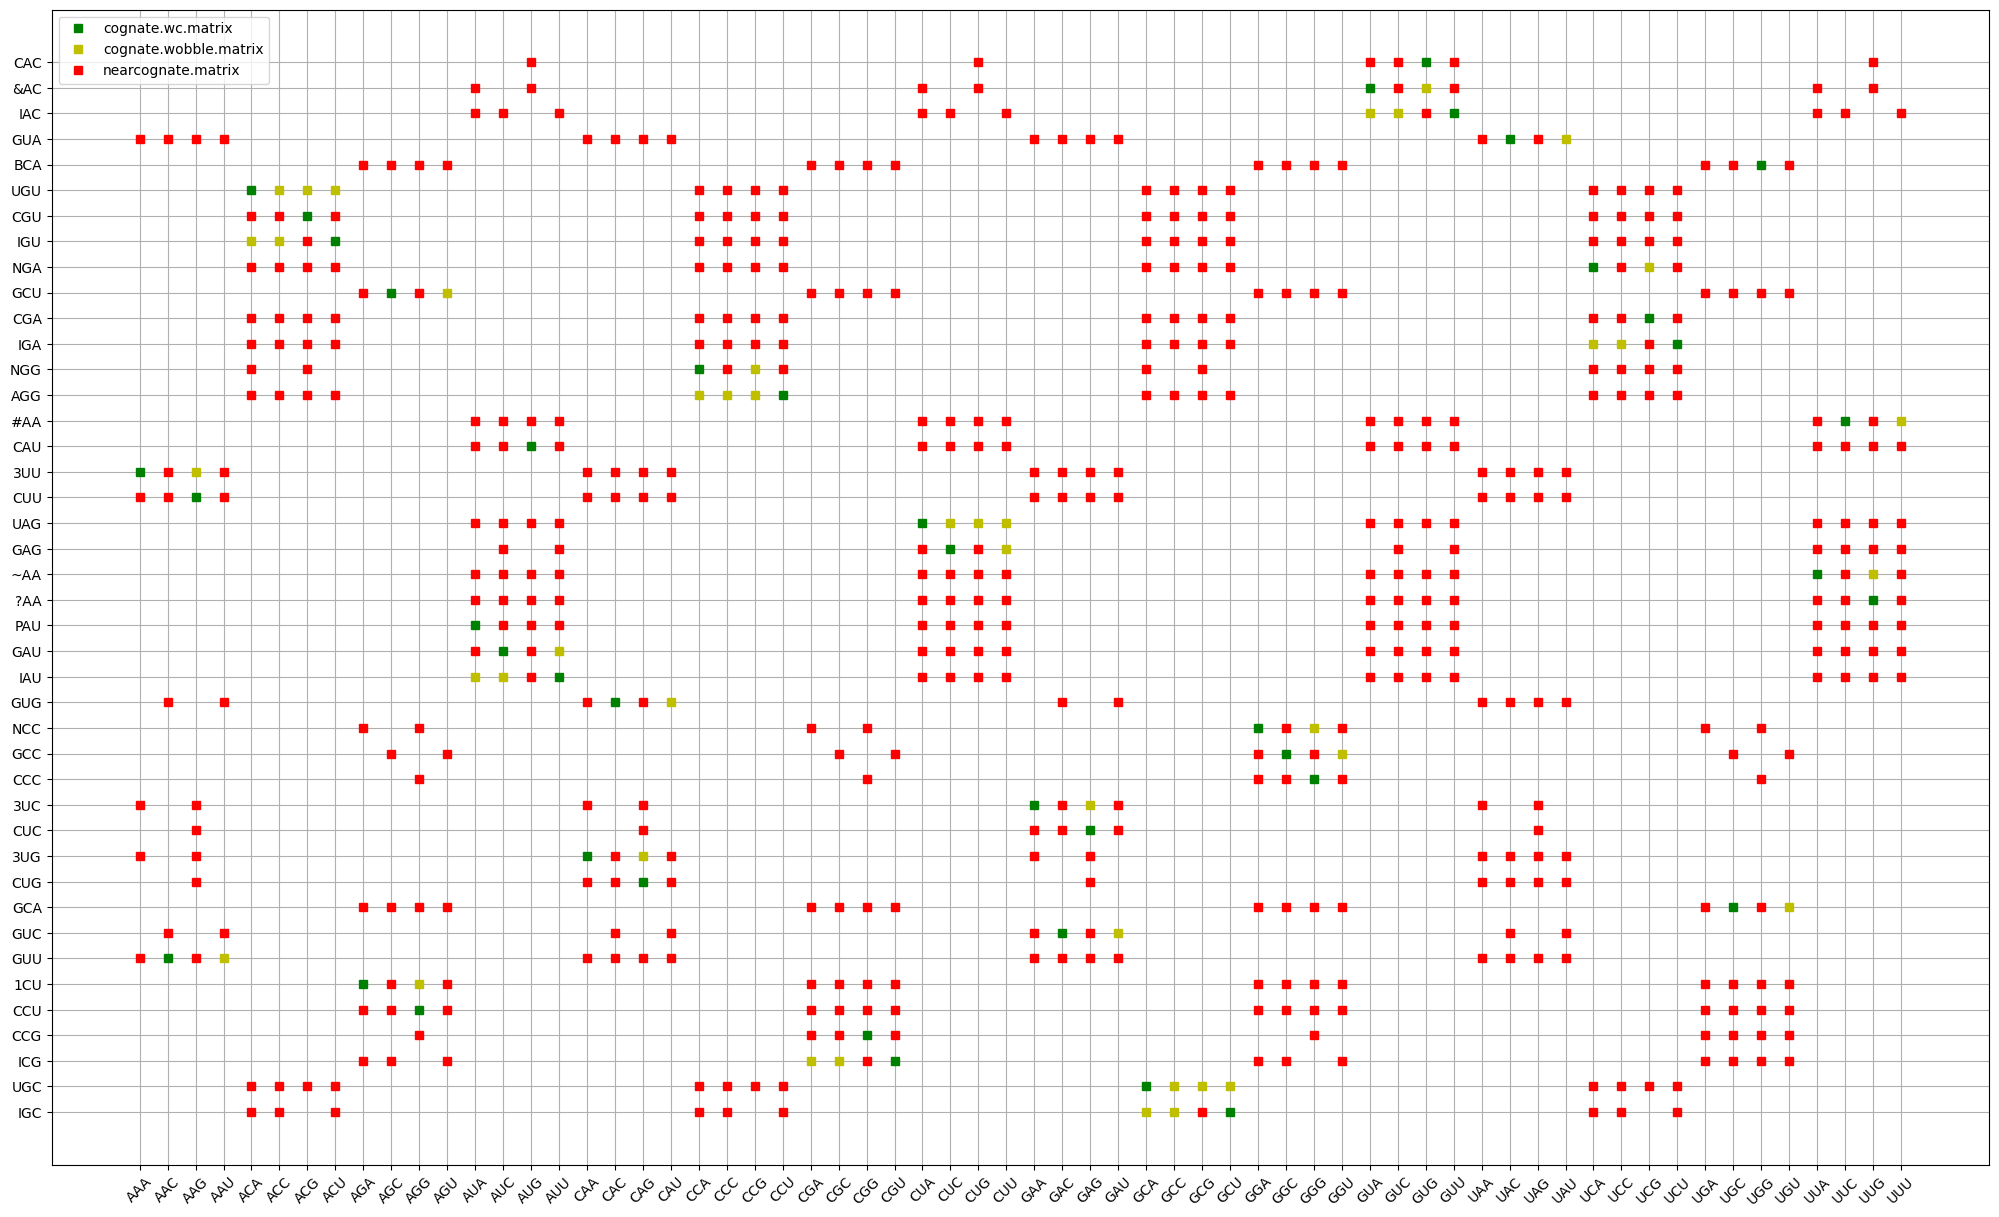

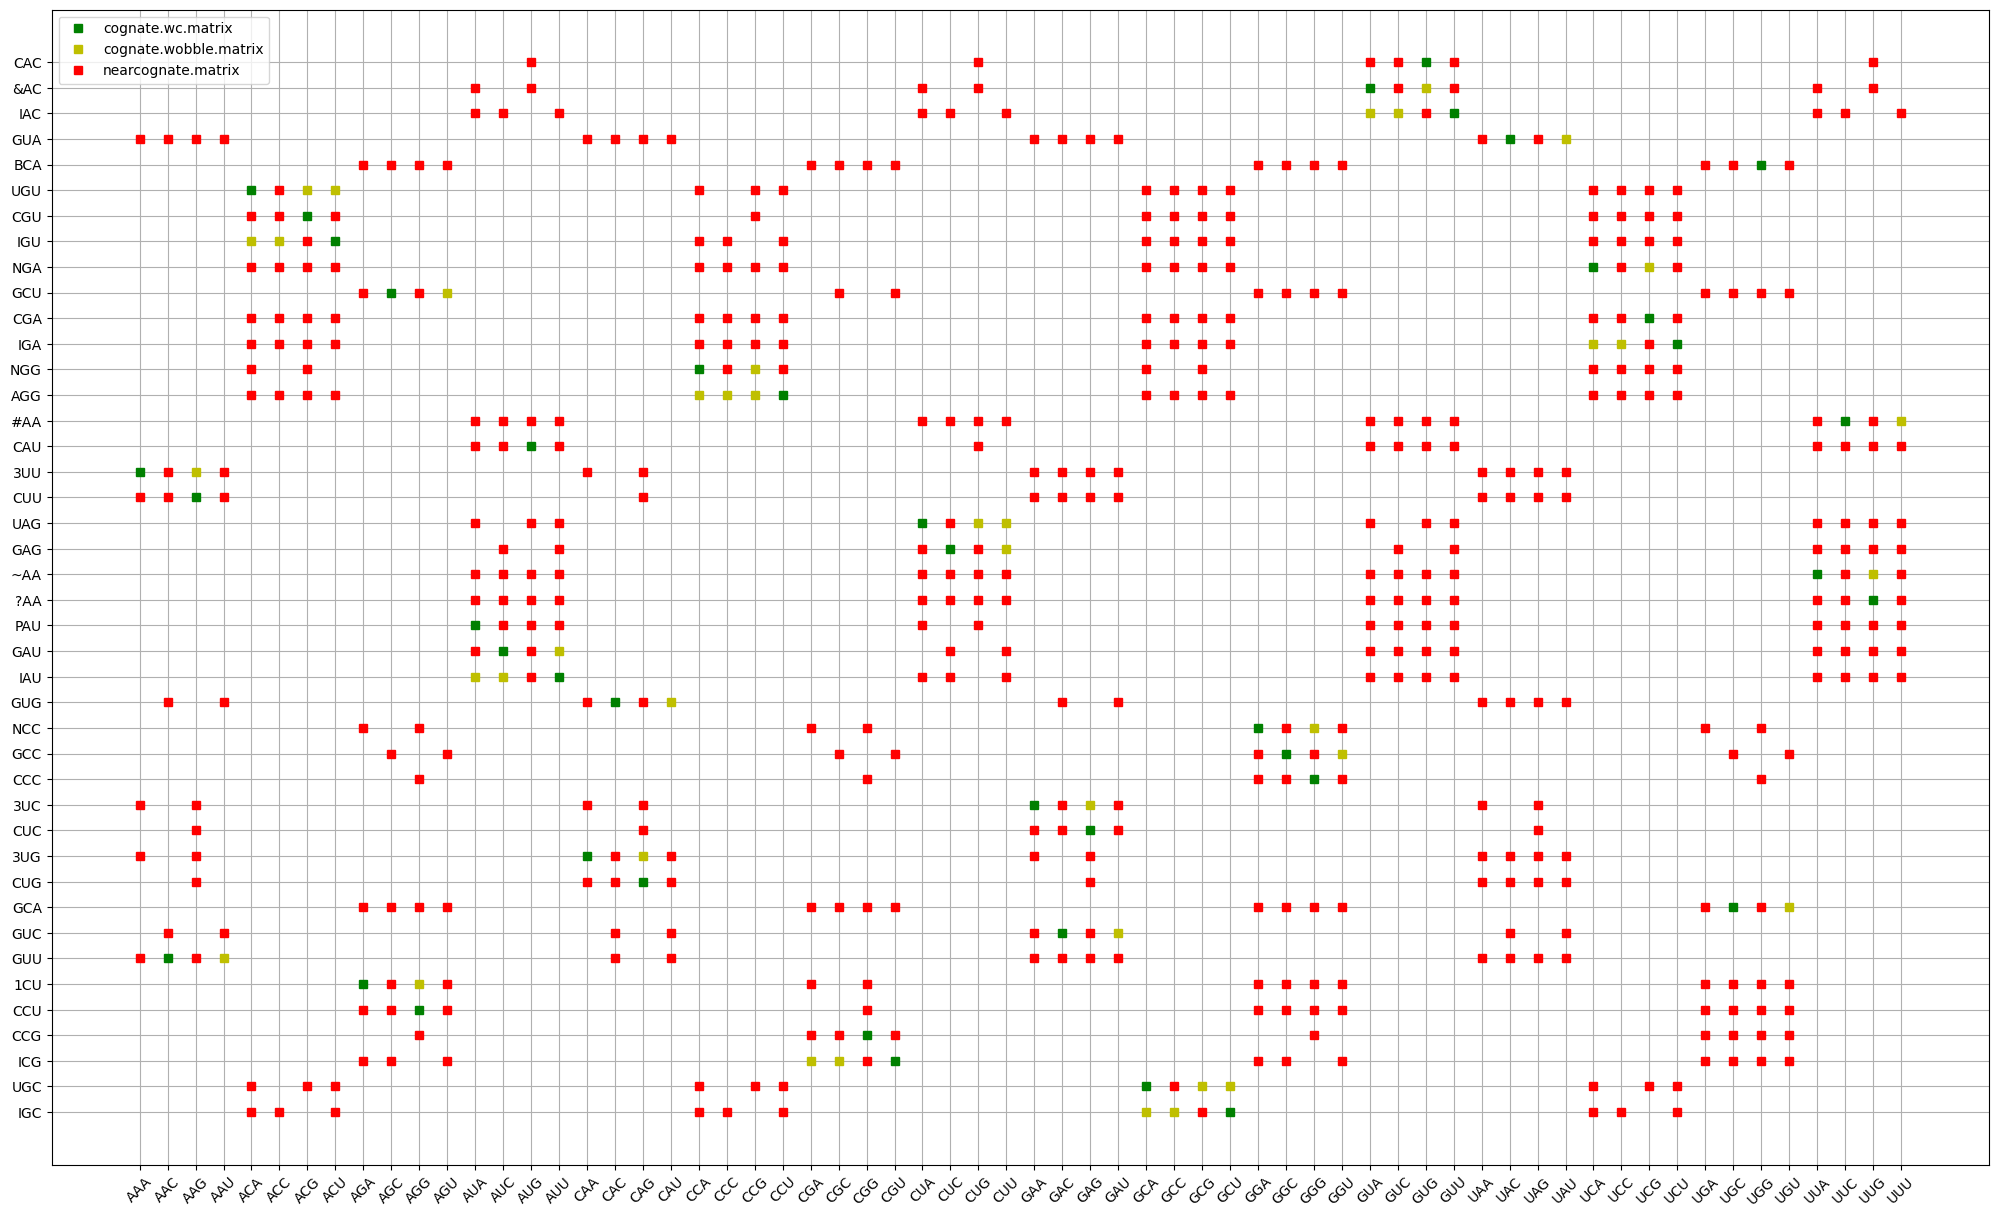

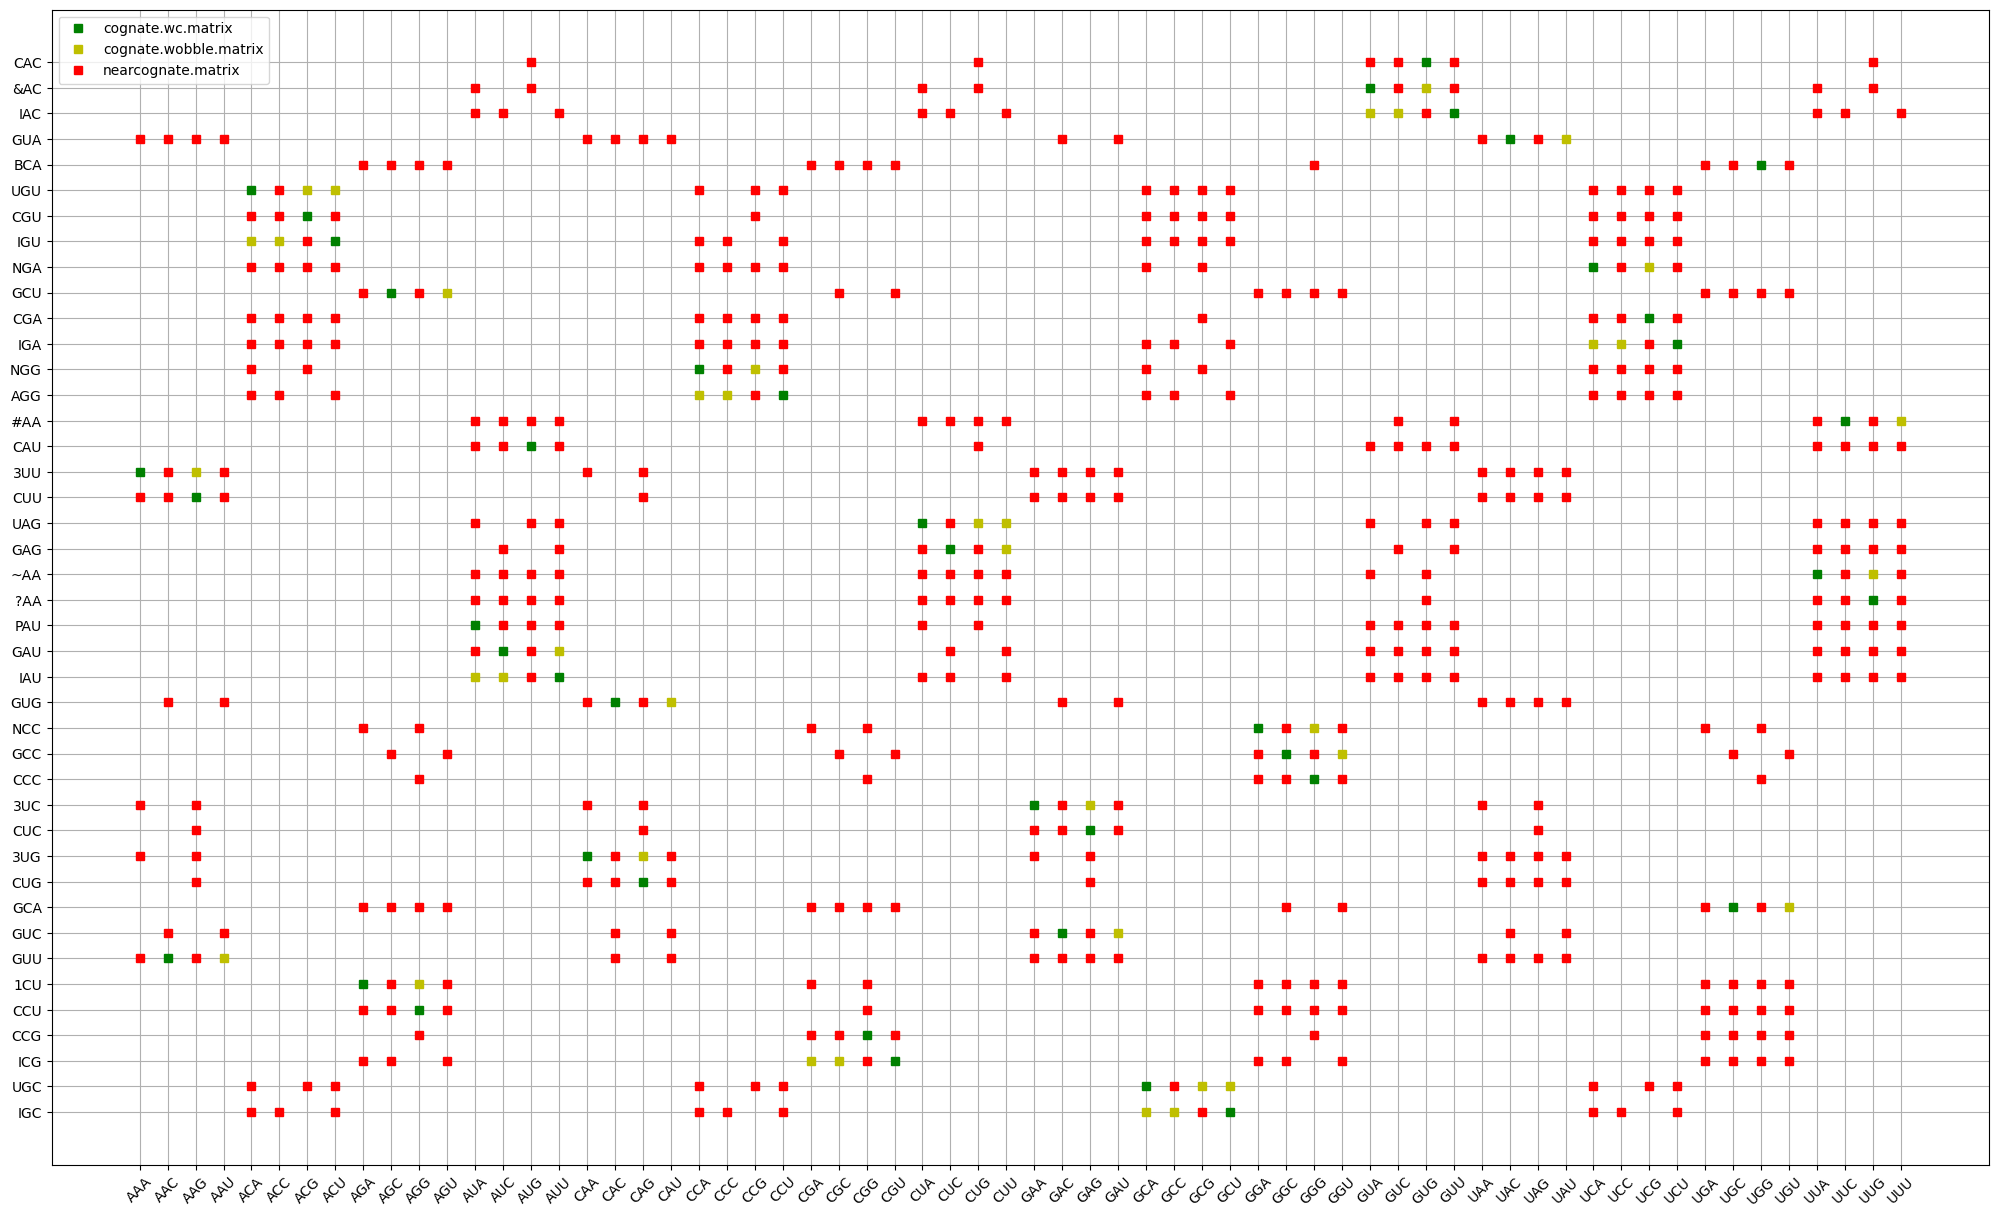

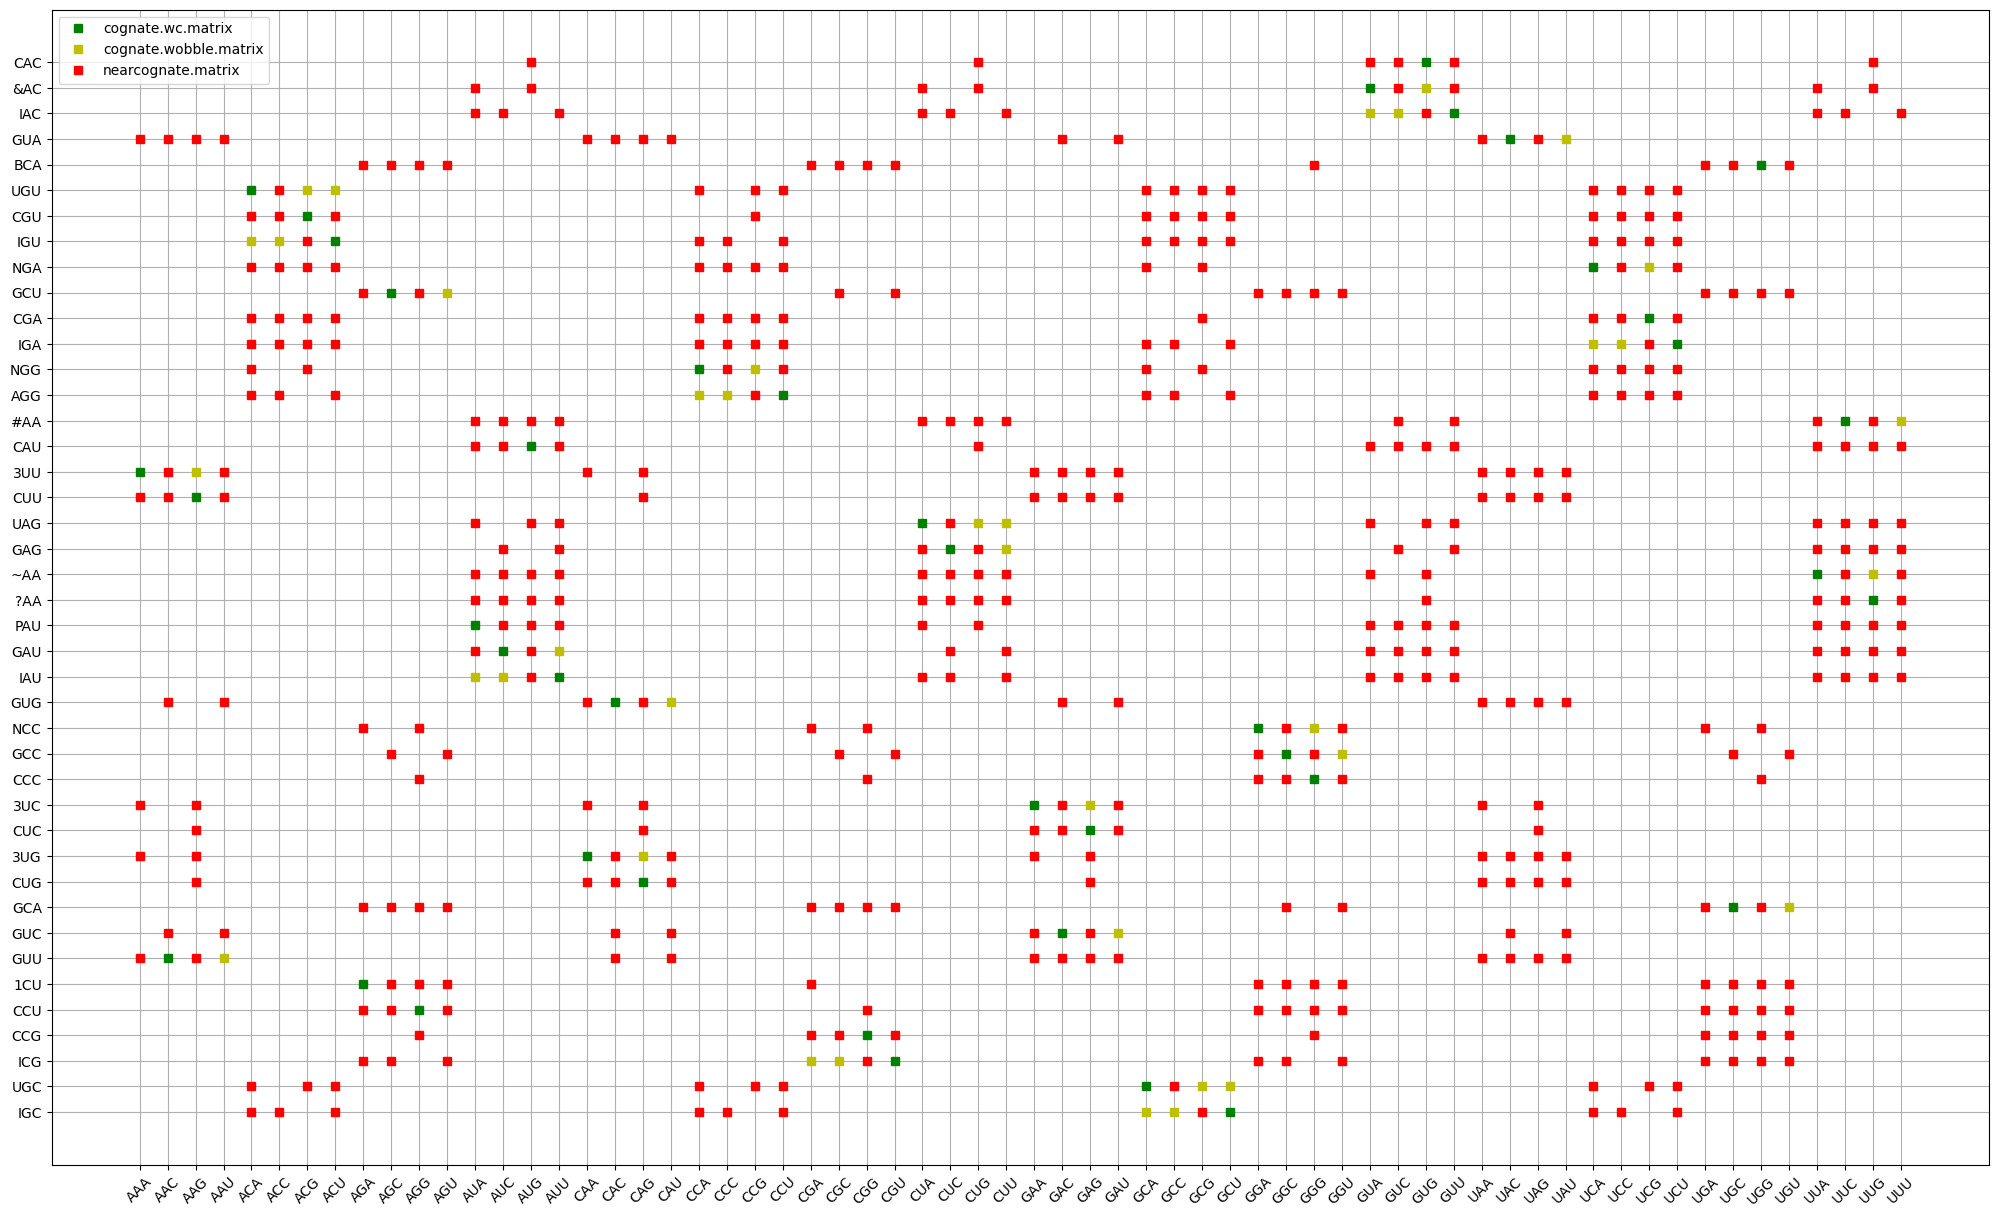

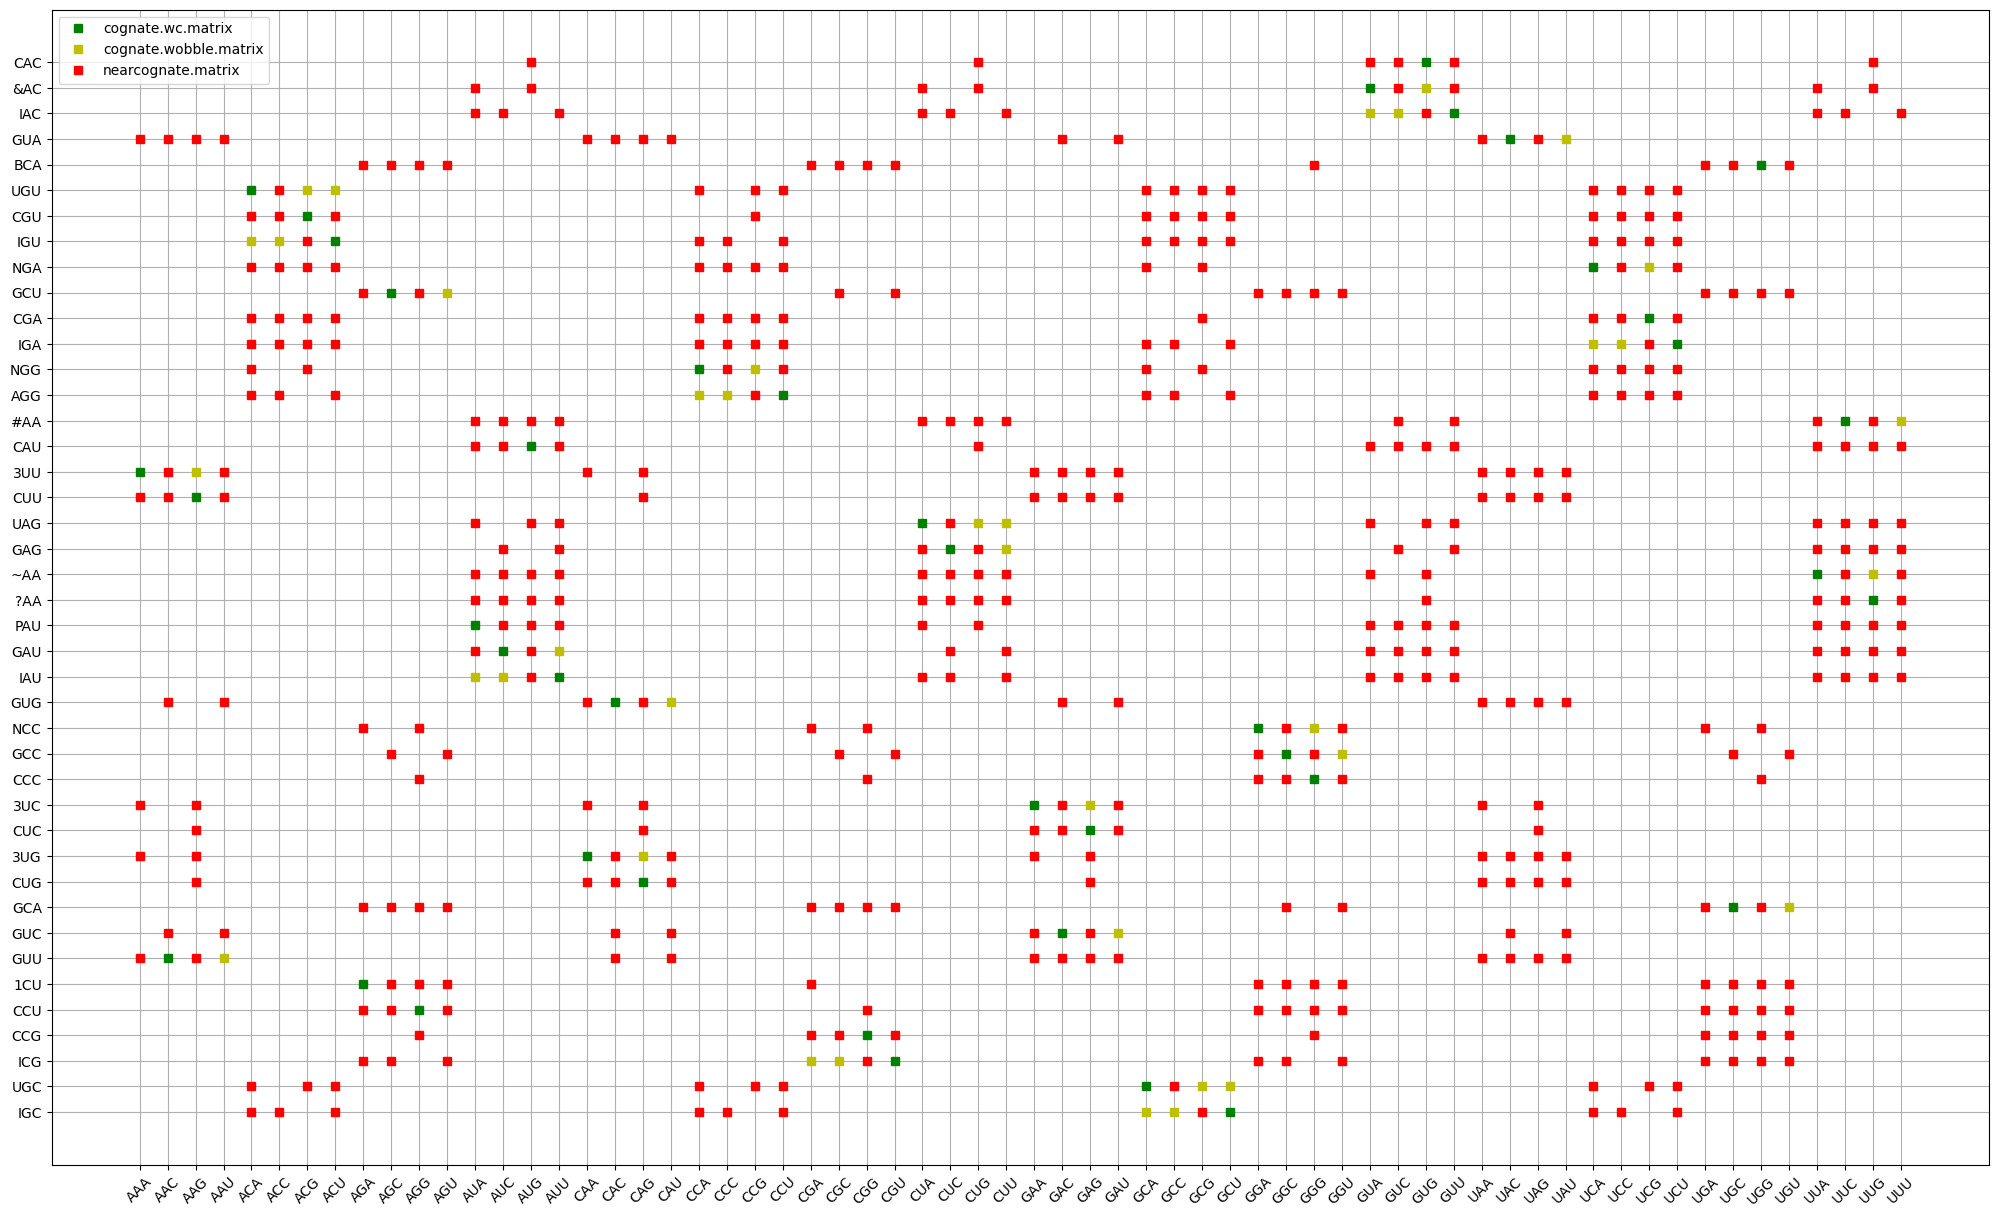

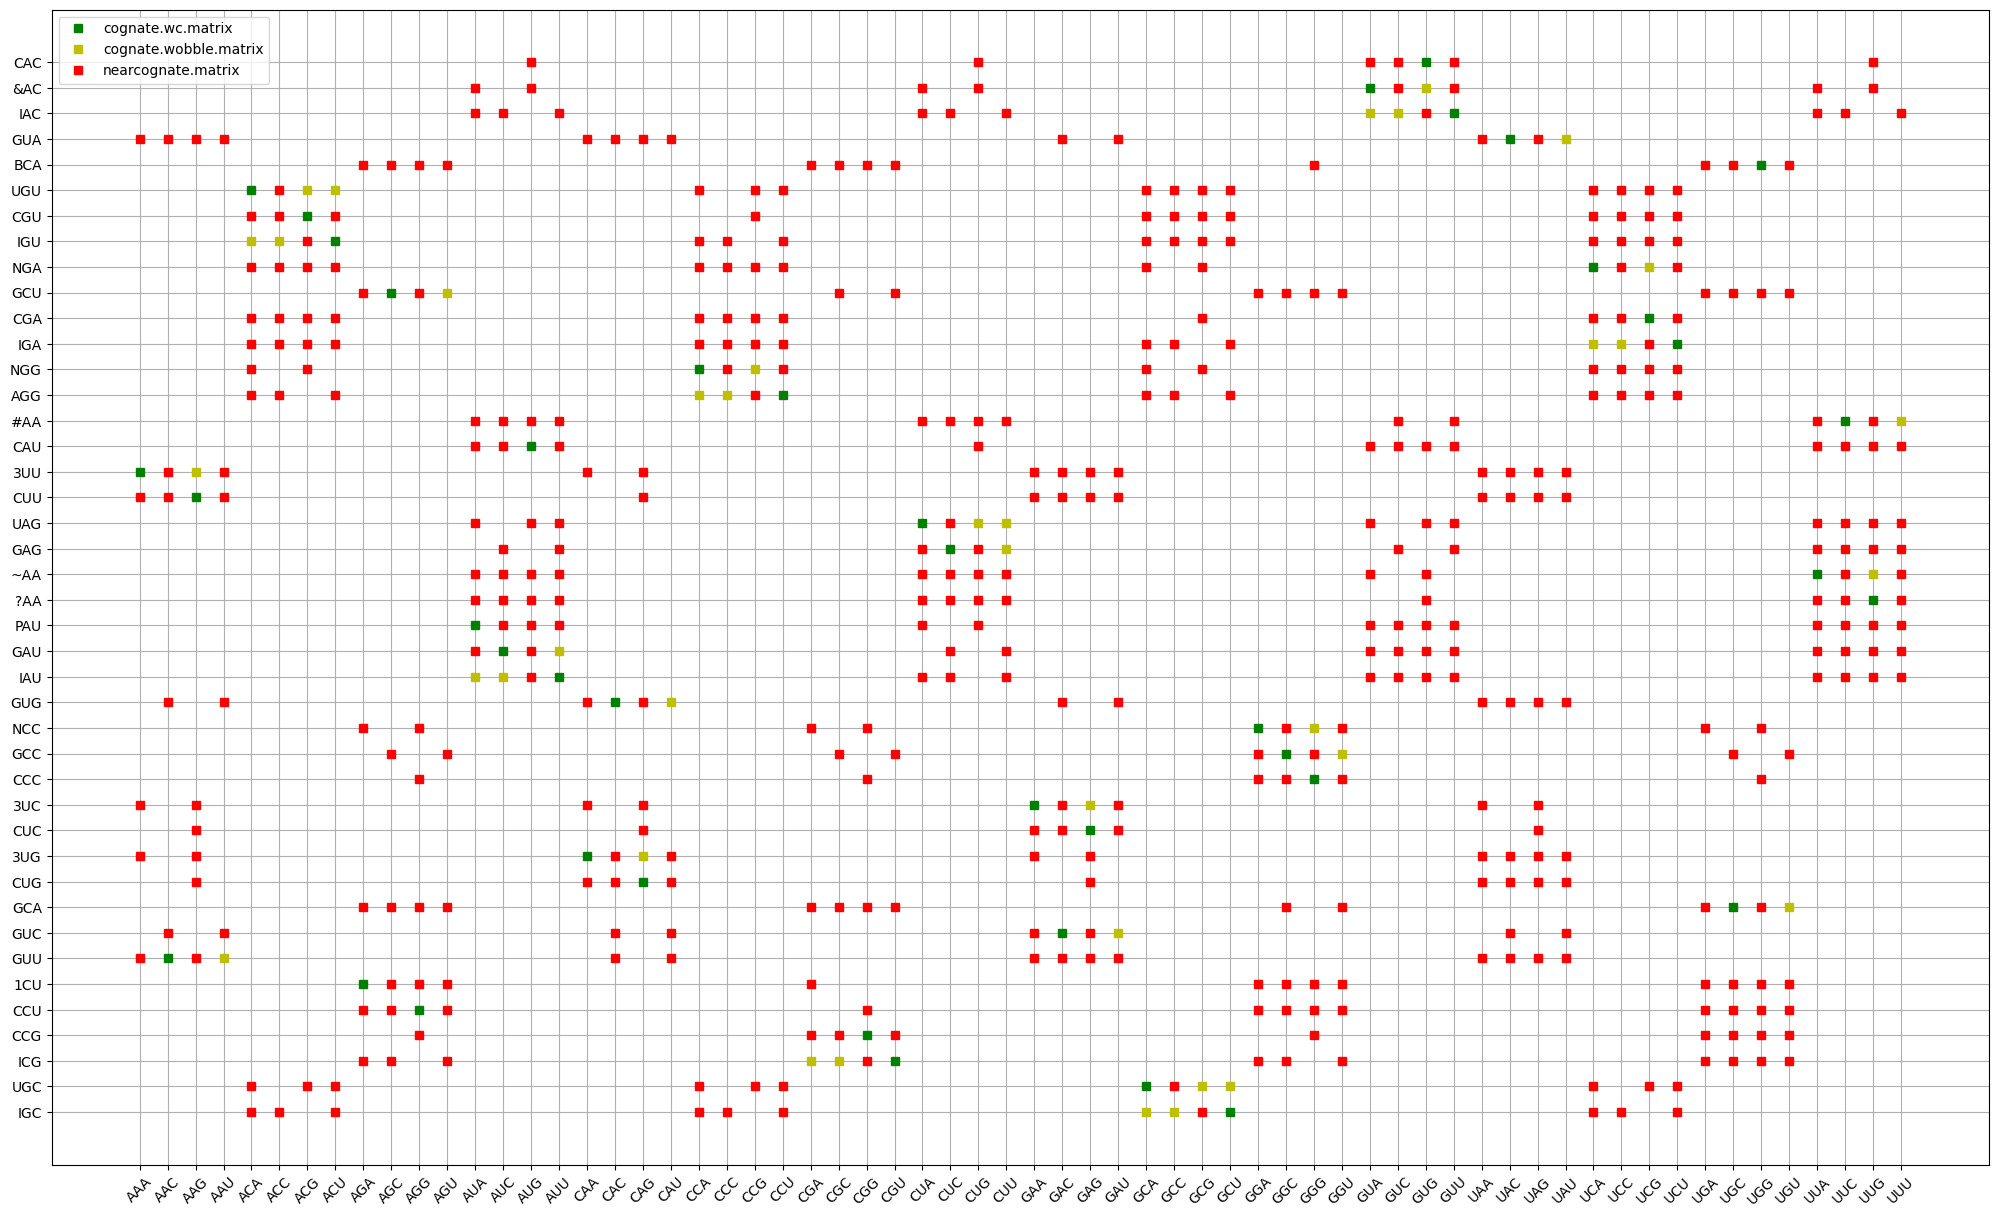

In [38]:
for c in constructs:
    for item in generate_sub_file_names(c):
        generate_plot(item)
